# Data Science - Assignment 1

### Zomato Bangalore Dataset

Kaggle link: https://www.kaggle.com/himanshupoddar/zomato-bangalore-restaurants

Team Members:
- Rajesh Kumar Gupta Lakshminarayan Gupta (B00791207)
- Vishaali Kadambur Srikanth (B00821049)

## 1) a) About the dataset
This dataset contains information about the restaurants in multiple locations across Bangalore. The information includes the restaurant types, the variety of food choices available, the approximate cost for two people in a particular restaurant, etc. Also, the key factors that indicate the success quotient of a restaurant like rating, number of people who've caused the rating have also been listed in the dataset. Details about facilities like online order, advanced booking of tables has also been provided.

Attribute-wise description has been provided along with the plots of the same.

In [0]:
!pip3 install category_encoders
!pip3 install skrebate
!pip3 install sklearn-relief

#### Import statements

In [0]:
import pandas as pd
import numpy as np
import pickle as pkl
import category_encoders as ce
import re
import warnings
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from skrebate import ReliefF
import sklearn_relief as relief
from datetime import datetime
warnings.filterwarnings("ignore")

#### Import visualization packages

In [0]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
%matplotlib inline

## 2) a) Loading CSV as Pandas DataFrame

In [0]:
rest_df = pd.read_csv("../content/drive/My Drive/Data Science - 5901 - A1/zomato.csv")

In [0]:
# Checking the first five rows of dataset  
rest_df.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


## 2) b) Plotting of frequency of attributes

### Attribute: Name

#### Using this attribute, we can come to the conclusion that if the value count of a restaurant is more than one, it belongs to a chain. This simple observation can be very handy during the prediction stages as the restaurants that belong to a chain might have price variation due to location but this is still valuable information. This will be encoded and used in this assignment for exploratory reasons.

In [0]:
# Get the count of names
rest_df_bar_name = rest_df.groupby("name").count()[["url"]].reset_index().rename(columns={"url":"count_names"})
rest_df_bar_name["chain_or_non_chain"] = rest_df_bar_name["count_names"].apply(lambda x: "chain" if x>1 else "non-chain")
rest_df_bar_name

,name,count_names,chain_or_non_chain
0,#FeelTheROLL,2,chain
1,#L-81 Cafe,9,chain
2,#Vibes Restro,3,chain
3,#refuel,3,chain
4,'Brahmins' Thatte Idli,1,non-chain
5,1 Fahreheit,1,non-chain
6,1000 B.C,6,chain
7,100ÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂ°C,3,chain
8,11 to 11 Express Biriyanis,2,chain
9,1131 Bar + Kitchen,6,chain


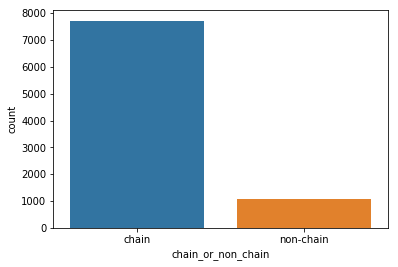

In [0]:
# Setting the axes of bar plot
sns.countplot(x=rest_df_bar_name["chain_or_non_chain"])

#### As you can see, the number of restaurant chains are more than 7000, while the number of non-chain restaurants are less. The restaurants existing in a chain will have a similar price range although it may differ according to location.

### Attribute: Location and Rest_type
#### Location and restaurant types can be visualised together to observe the type of restaurants that are prevalent across one location. Also, location can be visualised independently to check the average price in that area. This will give an insight into understanding the areas in Bangalore that have costly restaurants and cheap ones.

In [0]:
count_plot_loc = sns.countplot(x=rest_df["location"], hue=rest_df["rest_type"])

#### From the above plot, we can deduce that the casual dining restaurant types are more in each and every location. The graph is cluttered because there are too many locations and restaurant types. And also, the data has not been cleaned yet.

In [0]:
# Dropping rows that have null values in the target variable because they do not contribute to training the model
rest_df.dropna(subset=["approx_cost(for two people)"], inplace=True)

In [0]:
# Converting the target variable to integer datatype
rest_df["approx_cost(for two people)"] = rest_df["approx_cost(for two people)"].apply(lambda x: int(x.replace(",","")))

In [0]:
# Get the average price in a location
avg_price_loc_df = rest_df.groupby("location")["approx_cost(for two people)"].mean()
avg_price_loc_df = avg_price_loc_df.to_frame().reset_index()

### BAR PLOT: Avg Price in a Location Vs Location

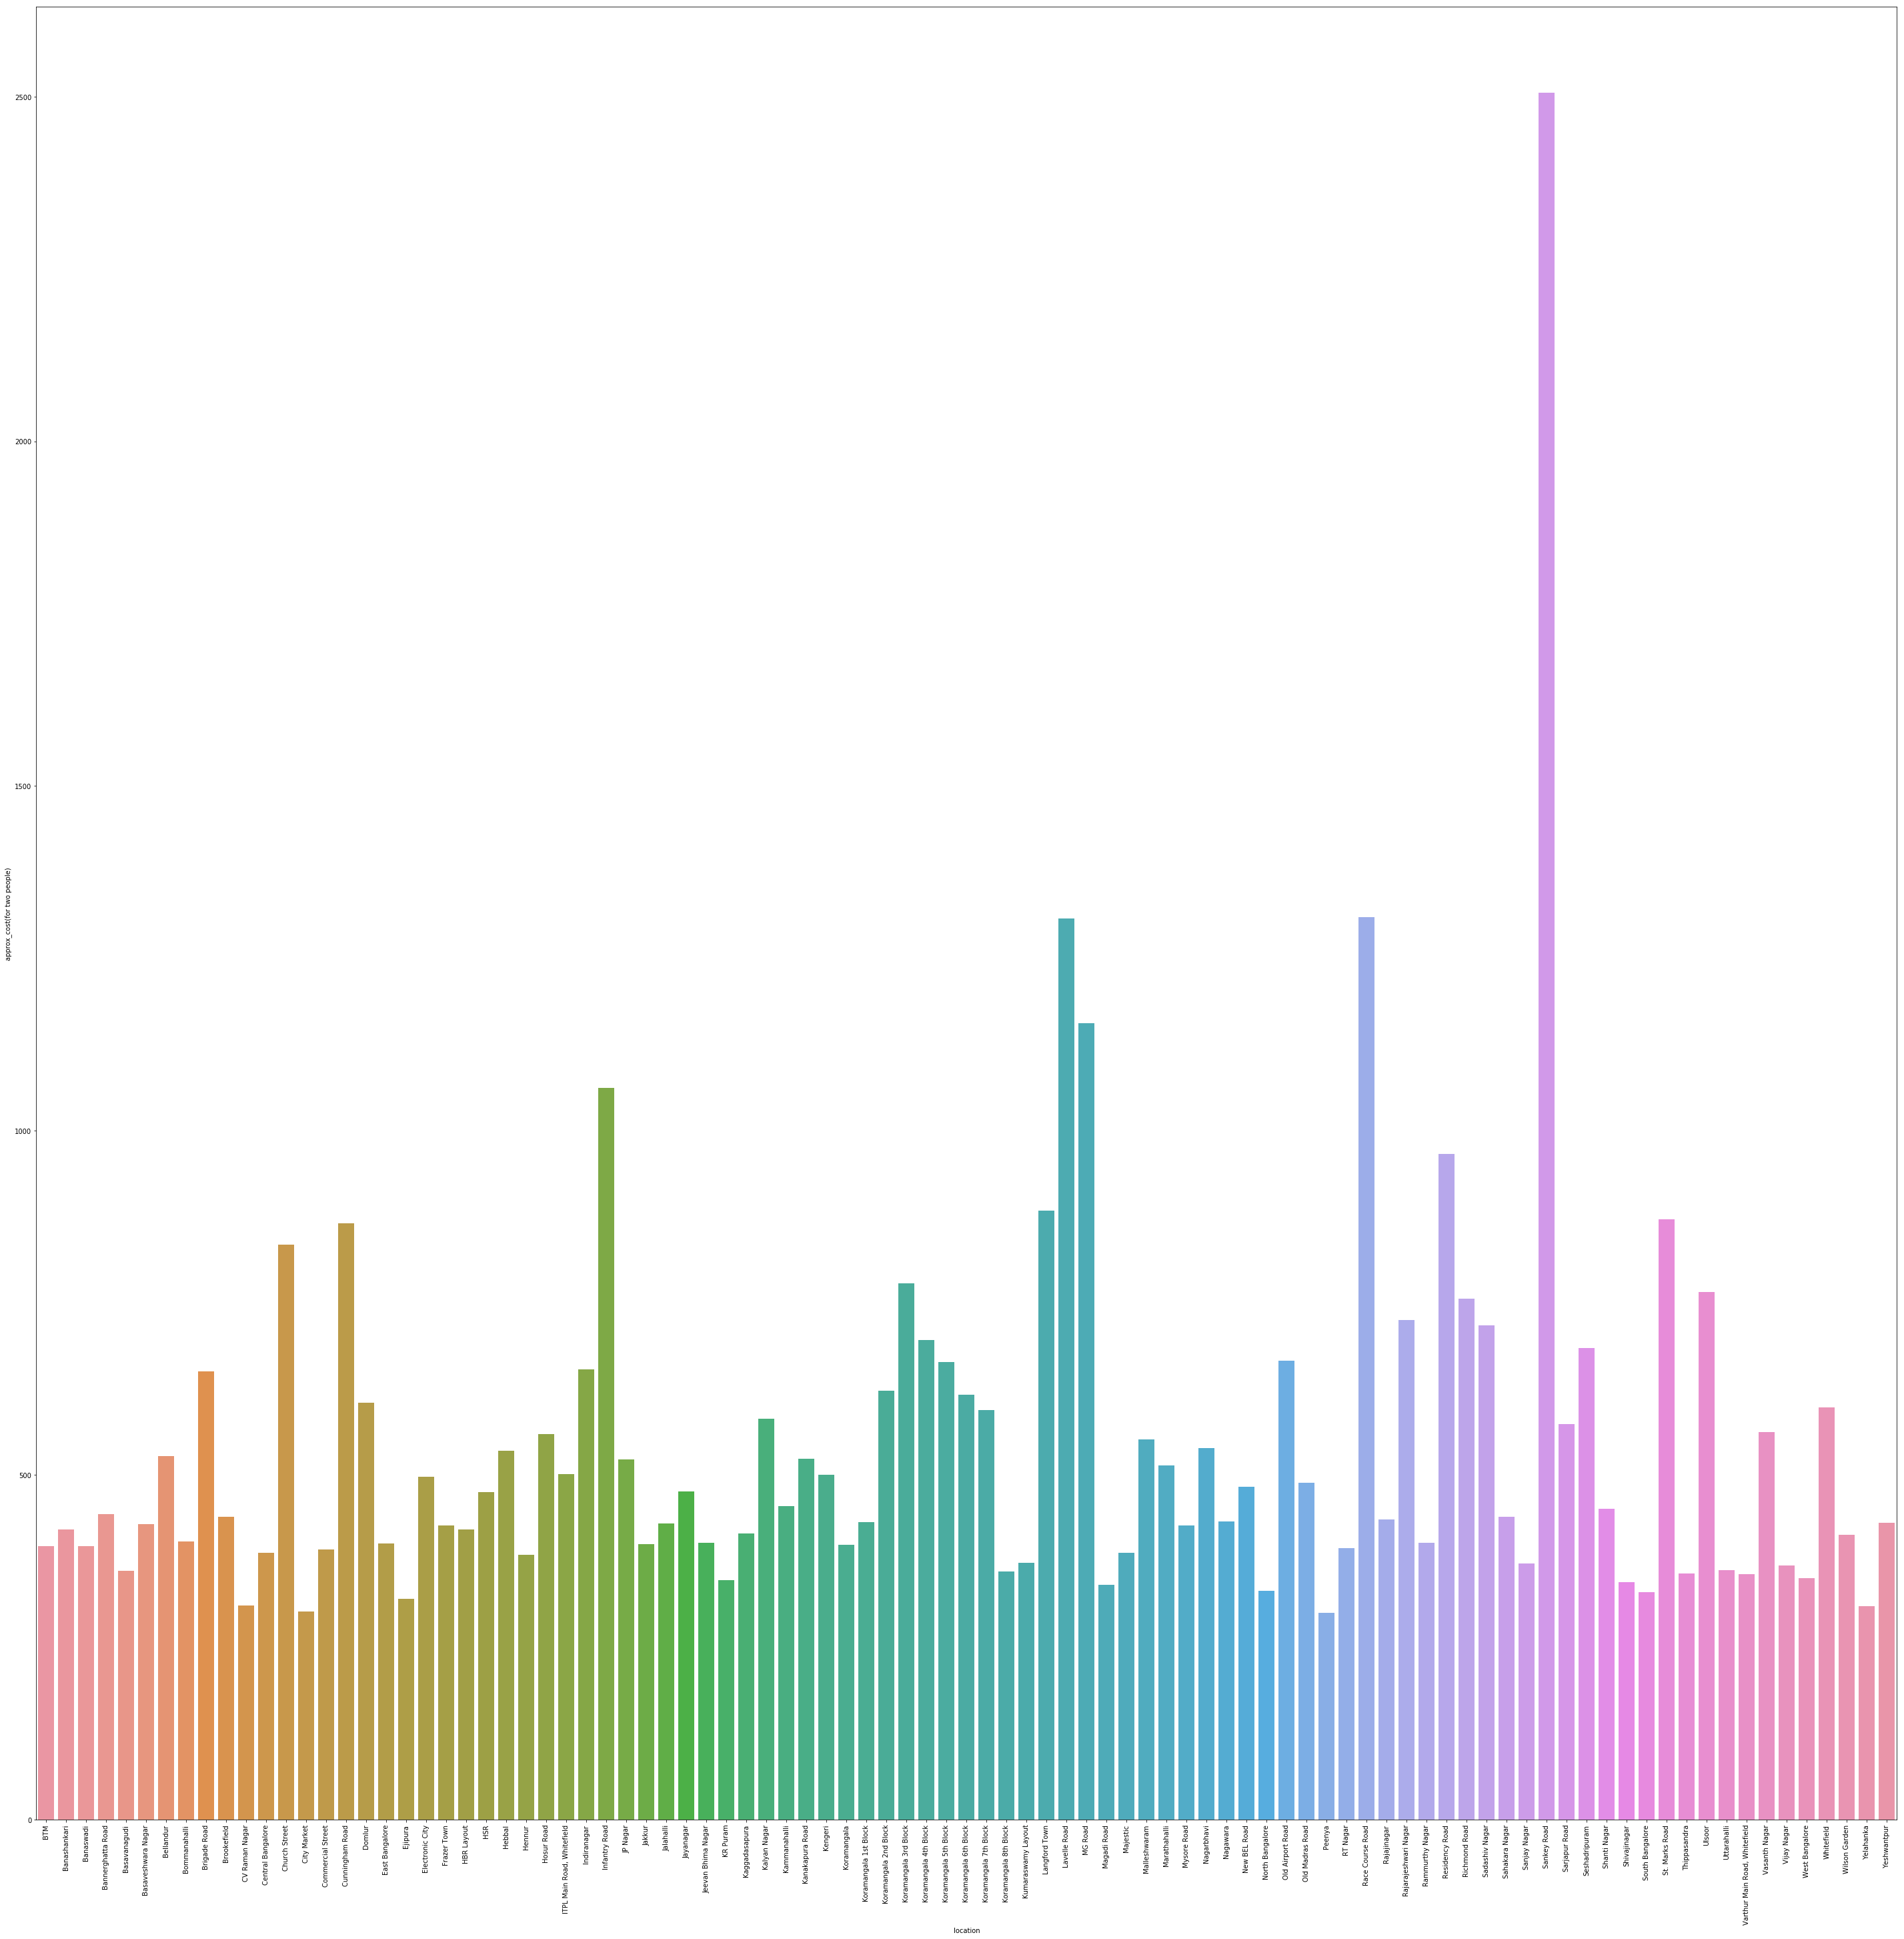

In [0]:
plt.figure(figsize=(50,50))
ax = sns.barplot(x="location", y="approx_cost(for two people)", data=avg_price_loc_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.close(2)

### Sankey Road has the highest average price in Bangalore. It can be inferred that it is a very posh area.

### COUNT PLOT: Most popular rest_type

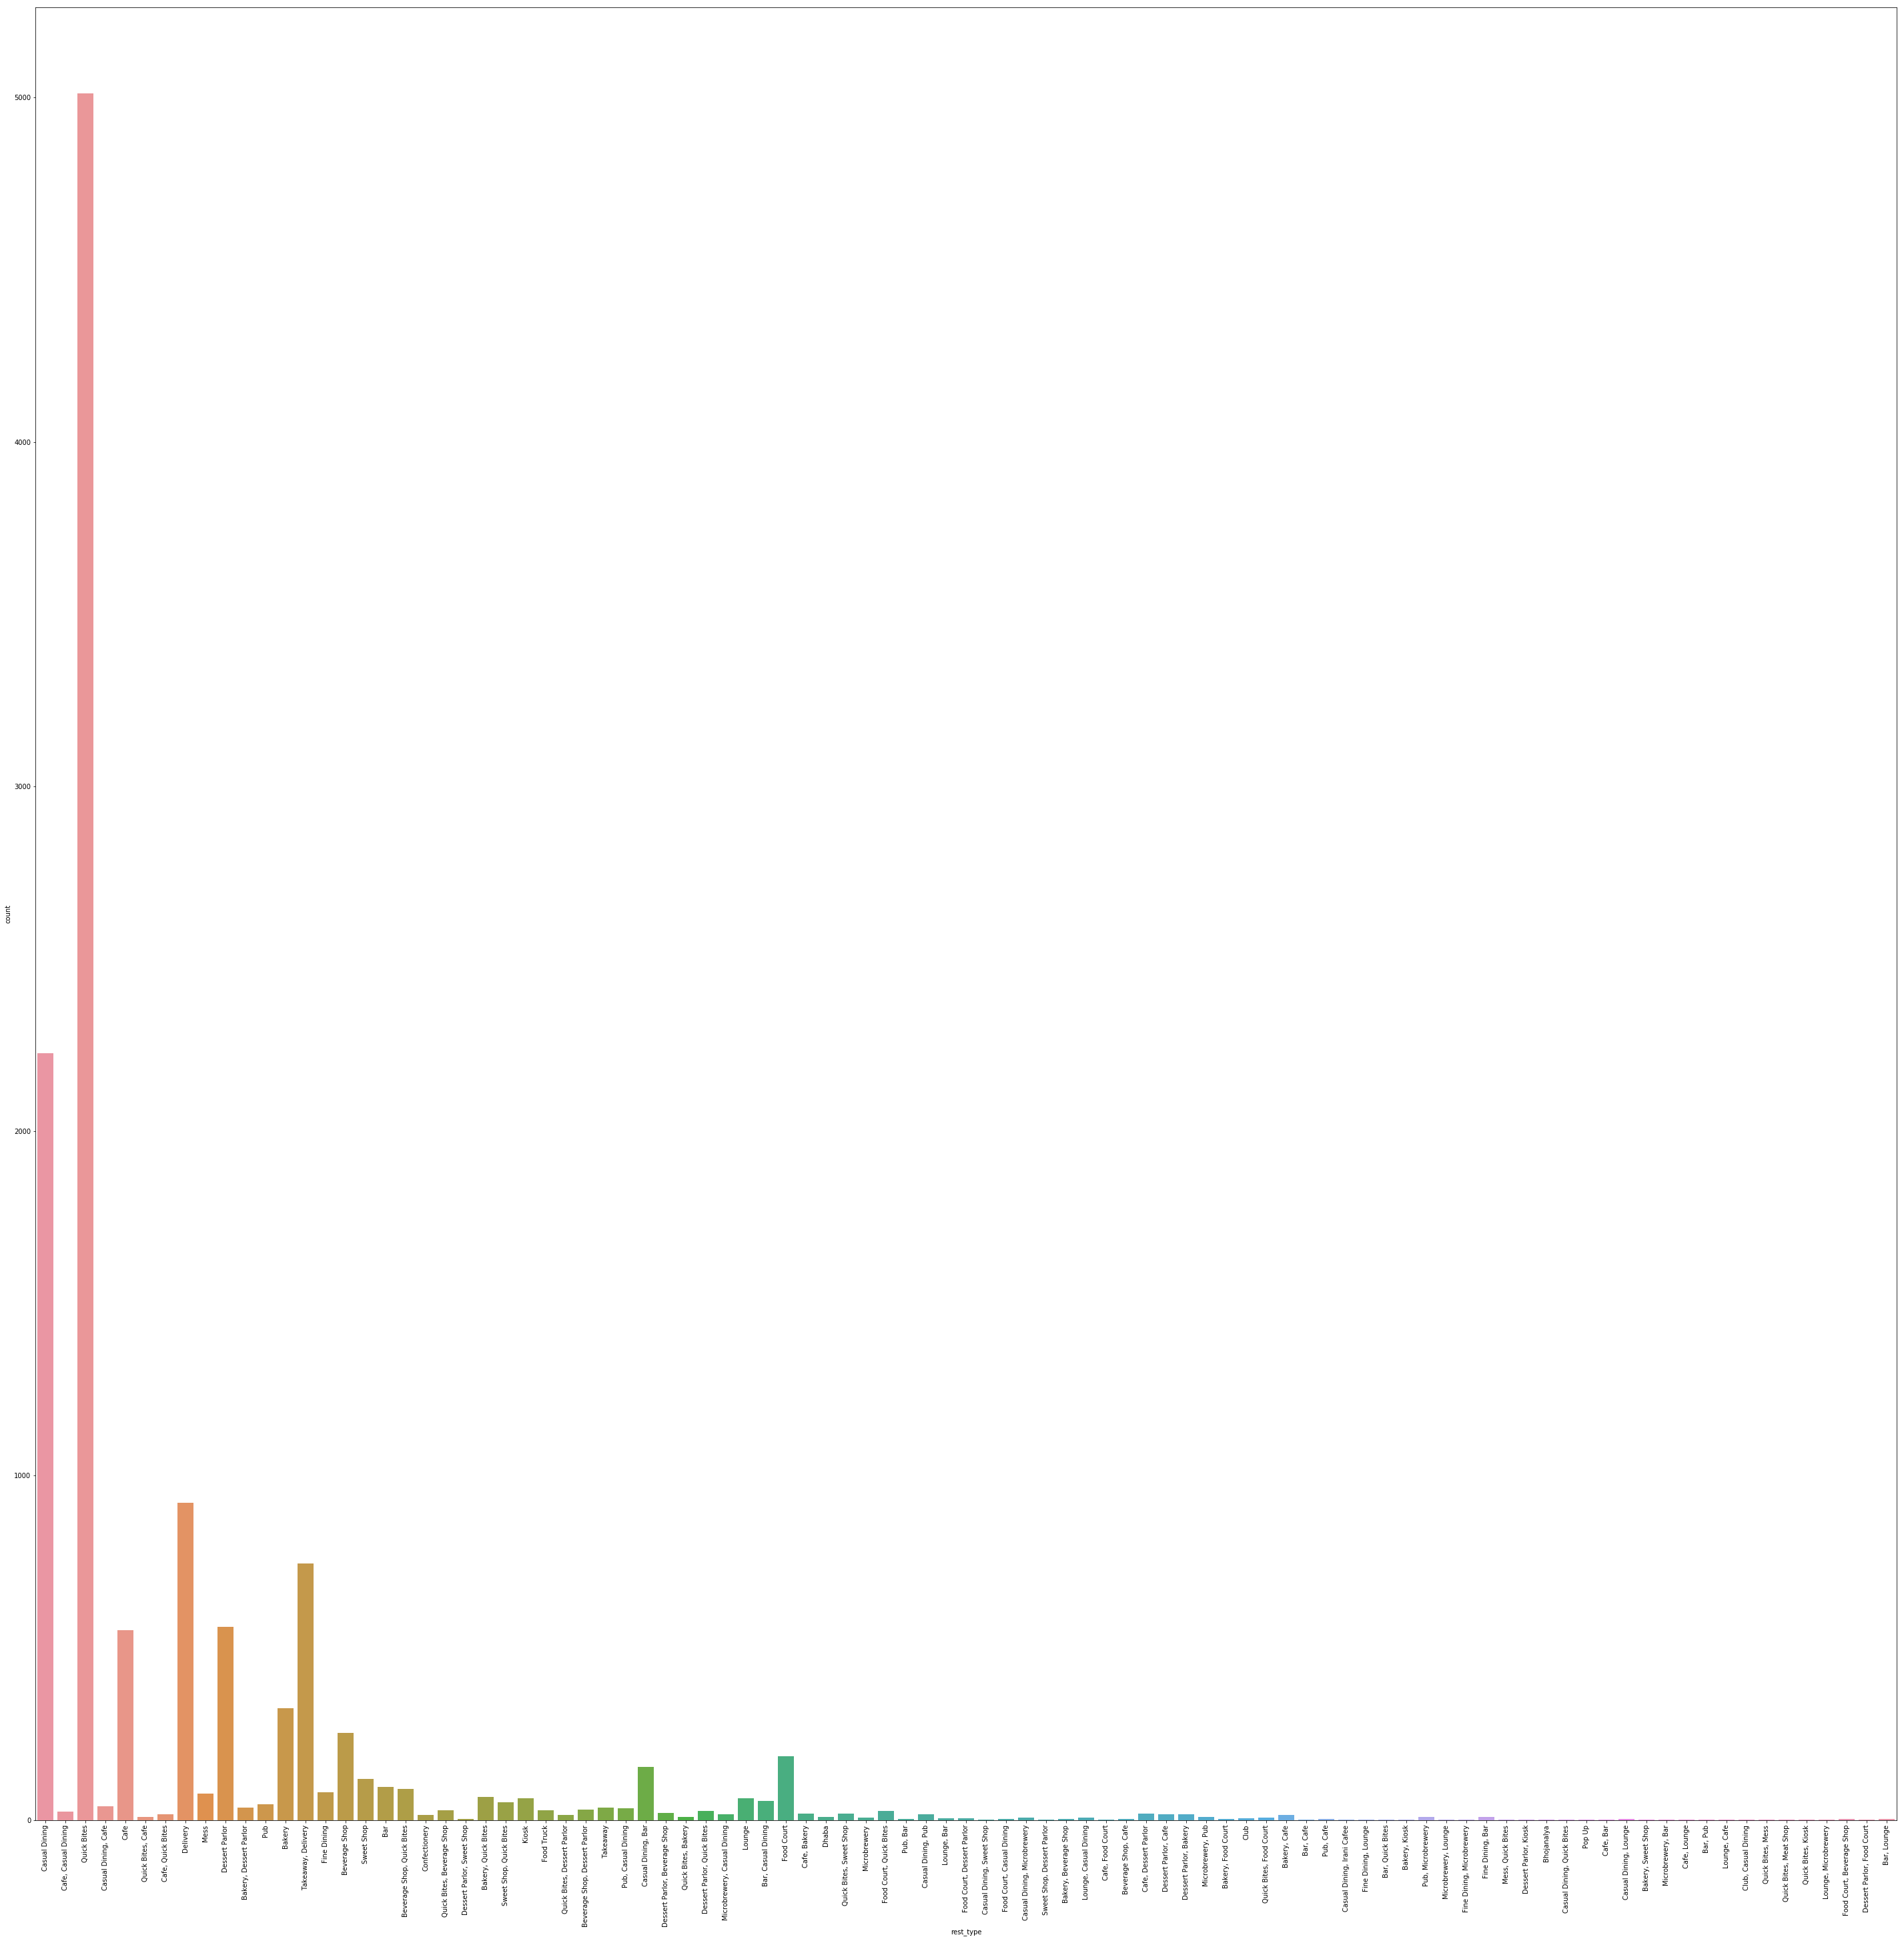

In [0]:
# Count plot to understand the most popular restaurant type
plt.figure(figsize=(50,50))
ax = sns.countplot(x="rest_type", data=rest_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

#### "Quick bites" are the most popular type of restaurant in Bangalore and this makes sense as well because the snack places are everywhere generally.

### Attribute: listed_in(type)
#### The restaurants that offer buffet services, delivery services, etc are listed in this column.

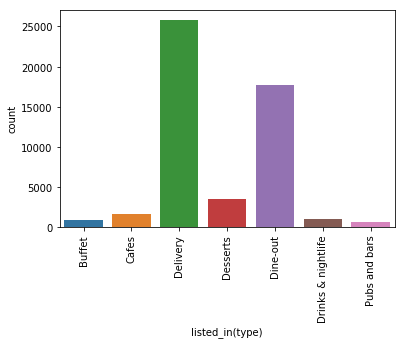

In [0]:
# Count plot to observe the type of restaurants available
ax=sns.countplot(x="listed_in(type)", data=rest_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

#### As we can see, most restaurants in Bangalore offer delivery services. But again, after the duplicates are dropped, the scenario might change.

### Attribute: online_order
#### From the graph, we can see that most of the restaurants in Bangalore offers online orders. 

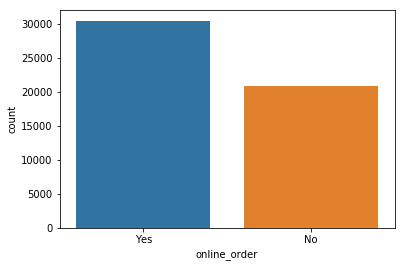

In [0]:
sns.countplot(x="online_order", data=rest_df)

### Attribute: book_table
#### The graph clearly shows that most of the restaurants in Bangalore does not allow booking of tables for dining. 

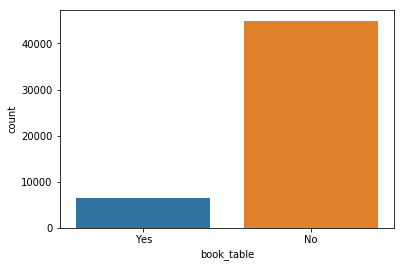

In [0]:
sns.countplot(x="book_table", data=rest_df)

### Attribute: rate

#### This attribute defines the rating of each restaurant. From this column, information like the restaurant with the highest rating or the location which has the highest average rating can be derived.

### PREPROCESSING "rate":
#### For this attribute, the null values or the newly opened restaurants that do not have any ratings have been provided with a mean rating of restaurants in the location same as the record for which the replacement is being done. There are also cases where the rating is null but the "reviews_list" attribute which has the ratings of several people is available. Hence, the rate column has been handled pretty effectively. The reason for substituting the null values or new values of "rate" attribute in this fashion is because these new/null values should not affect the location's average rating on the whole.  

In [0]:
# Converting string literals in reviews_list to a list of tuples to derive rate
rest_df["reviews_list"] = rest_df["reviews_list"].apply(lambda x: eval(x))

In [0]:
# Helper function to calculate avg rating from reviews_list
def rate_calculator(data):
    if not isinstance(data[0], str):
        try:
            # Null rate -> Review list present
            rates = [float(i[0].strip().replace("Rated", "")) for i in data[1] if i[0] is not None]
            return pd.Series([sum(rates)/len(rates), data[1]])
        except Exception as e:
            # Null rate -> No review list
            return pd.Series([np.nan, data[1]])
    else:
        try:
            # "4.1/5"
            return pd.Series([float(data[0].replace("/5","")), data[1]])
        except:
            # "NEW" or ""-"
            return pd.Series([np.nan, data[1]])

In [0]:
# Applying helper function on dataframe
rest_df[["rate","reviews_list"]] = rest_df[["rate", "reviews_list"]].apply(rate_calculator, axis=1)

In [0]:
rest_df.isnull().sum()

url                                0
address                            0
name                               0
online_order                       0
book_table                         0
rate                            7501
votes                              0
phone                            874
location                           0
rest_type                        204
dish_liked                     27868
cuisines                          19
approx_cost(for two people)        0
reviews_list                       0
menu_item                          0
listed_in(type)                    0
listed_in(city)                    0
dtype: int64

In [0]:
# New df to store location and average rating
avg_rating_df = rest_df.groupby("location")["rate"].mean().to_frame().reset_index()

In [0]:
# Function to substitute NaNs with mean rate of the corresponding location
rest_df["rate"] = rest_df.groupby("location").transform(lambda x: x.fillna(x.mean()))

In [0]:
rest_df.rate.isnull().sum()

3

#### There are still 3 null values because the record with NaNs doesn't have more than one record for the corresponding location column to get a mean. For instance, location X has only one record and the rating is NaN, in this case, it is not possible to derive mean and hence, the overall mean rating has been used. 

In [0]:
rest_df.rate.fillna(rest_df.rate.mean(), inplace=True)

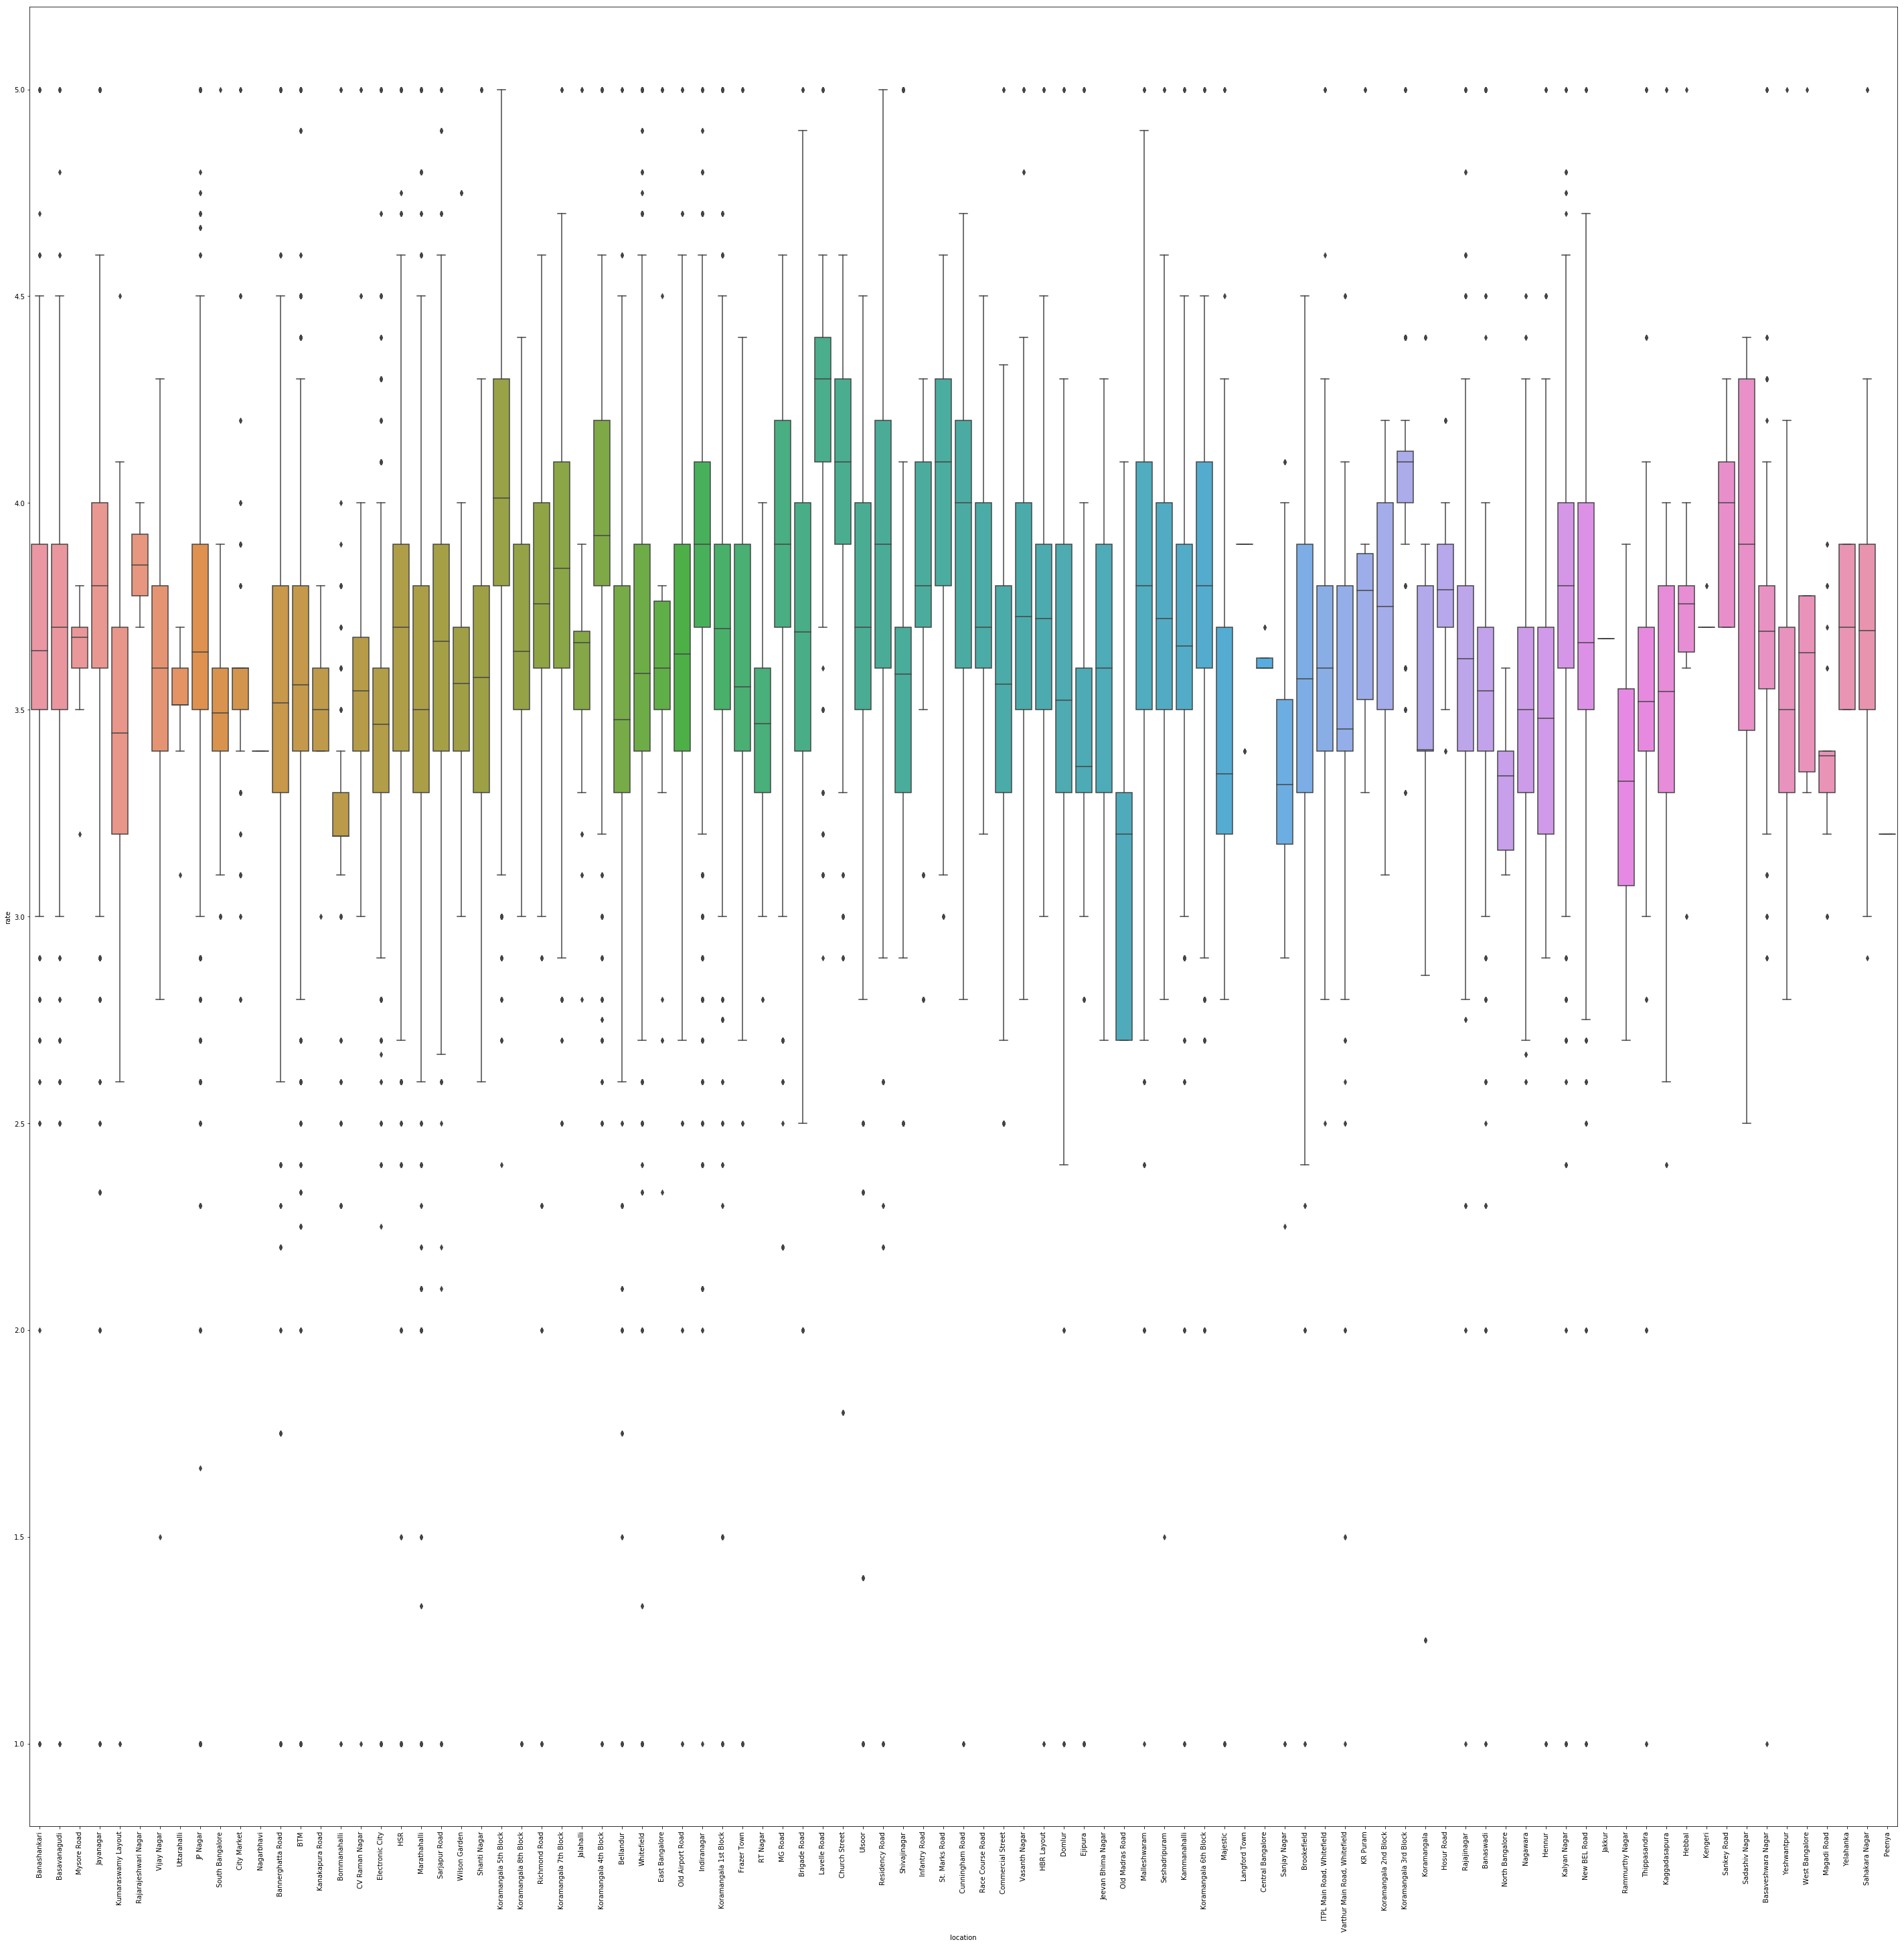

In [0]:
plt.figure(figsize=(50,50))
ax = sns.boxplot(x="location", y="rate", data=rest_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

#### From the above box plot for rating against location, we can observe how the restaurant's ratings are distributed across a location along with the outliers. For example, Lavelle Road seems to have restaurants that range from a rating of 4.1-4.5 although the restaurants present are not too many. This is relatable as Lavelle Road is considered to have some of the finest architectural buildings and is a high quality area in Bangalore. 

## Printing the column names

In [0]:
rest_df.columns

Index(['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'phone', 'location', 'rest_type', 'dish_liked', 'cuisines',
       'approx_cost(for two people)', 'reviews_list', 'menu_item',
       'listed_in(type)', 'listed_in(city)'],
      dtype='object')

### There are certain attributes that have been plotted after dropping the duplicates as the duplicates (~38000) affect the inference in a significant manner. 
### NOTE: 2)b) will now be continued after answering 2)c)

## 2) c) Dropping the duplicates based on "name" and "address"

#### Yes, there are duplicates in this dataset. We have used a combination of "name" and "address" to drop the rows as it provides redundant restaurant details.

In [0]:
rest_df.drop_duplicates(["address", "name"], keep="first", inplace=True)

In [0]:
# Printing the shape of the dataframe
rest_df.shape

(12444, 17)

### Attribute: Cuisines
#### This attribute lists the type of cuisine available in a restaurant. This attribute can be plotted against the location to understand which location has the most number of cuisine combos.

### COUNT PLOT: UNIQUE CUISINES IN LOCATION vs LOCATION

In [0]:
rest_df.dropna(subset=["cuisines"], inplace=True)

In [0]:
unique_cuisines_df = rest_df.groupby("location")["cuisines"].count().reset_index()

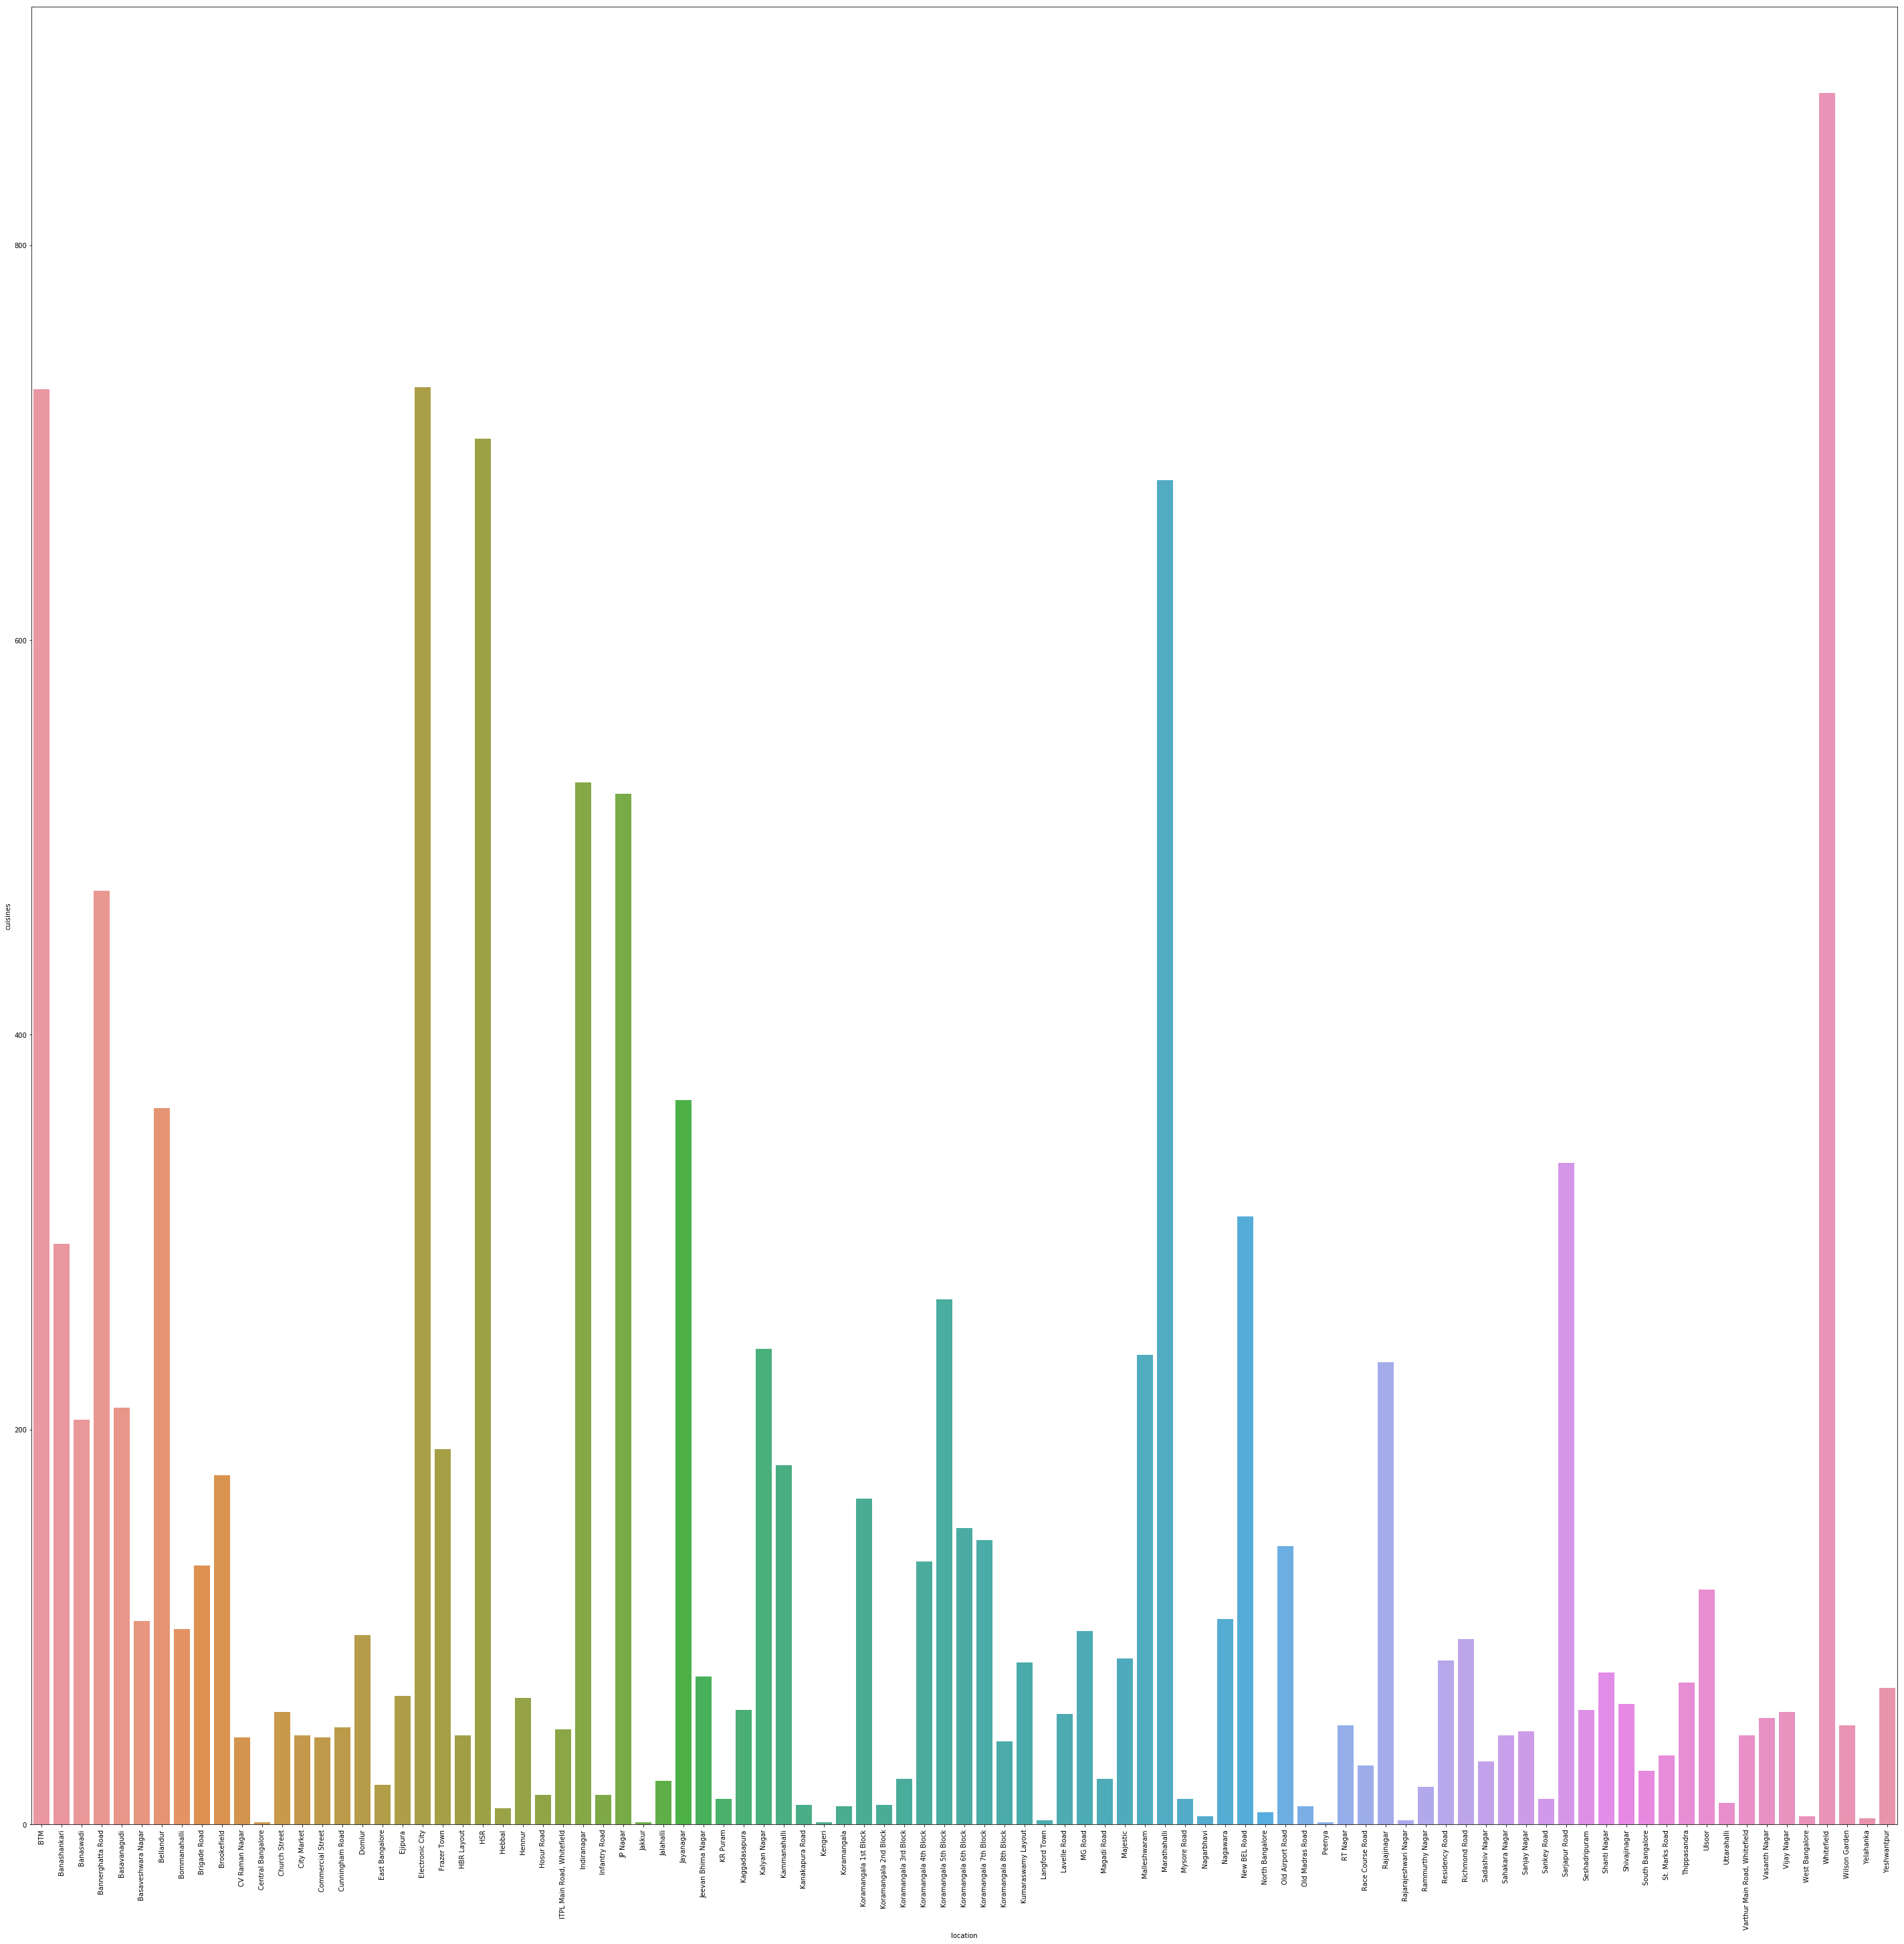

In [0]:
plt.figure(figsize=(50,50))
ax=sns.barplot(x="location", y="cuisines", data=unique_cuisines_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

### From this plot, we can observe that "Whitefield" is the area that has the most number of cuisine combinations.

## 2) b) [Continued] Dropping the irrelevant columns

### There are certain columns that can be dropped straightaway because they do not contribute to the target variable in any way. For instance, columns like "url" , "phone" is not going to help predict the approximate cost for 2 people in a restaurant. This relevance of columns initially is determined using the domain knowledge about the problem. The dropping of other columns can be done further along the way as we dig deeper into the specifics.

### Dropped columns: ["url", "address", "dish_liked", "menu_item", "listed_in(city)", "phone"]

In [0]:
# Dropping columns
rest_df.drop(["url", "address", "dish_liked", "menu_item", "listed_in(city)", "phone"], axis=1, inplace=True)

In [0]:
# Printing shape after removal of columns
rest_df.shape

(12434, 11)

In [0]:
# Check the number of null values in each column
rest_df.isnull().sum()

name                            0
online_order                    0
book_table                      0
rate                            0
votes                           0
location                        0
rest_type                      54
cuisines                        0
approx_cost(for two people)     0
reviews_list                    0
listed_in(type)                 0
dtype: int64

### Examining the column "online_order" to determine its relevance

### Scatter plot 1: ONLINE_ORDER vs APPOX_COST

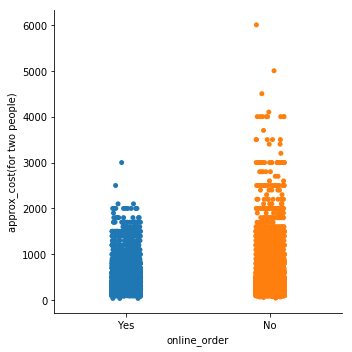

In [0]:
sns.catplot(x="online_order", y="approx_cost(for two people)", data=rest_df)

### Scatter plot 2: BOOK_TABLE vs APPOX_COST

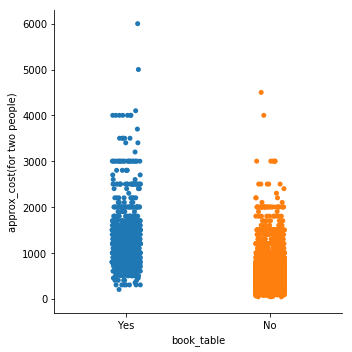

In [0]:
sns.catplot(x="book_table", y="approx_cost(for two people)", data=rest_df)

### Inference:
#### From the above scatter plots, we can deduce that "online_order" and "book_table" do not have any relevance with respect to the target variable i.e. there is no scope to differentiate. For instance, both in scatter plot 1 & 2, the categorical values "yes" and "no" pretty much fall under the same price range. Hence, both the columns are dropped.

In [0]:
rest_df.drop(["online_order", "book_table"], axis=1, inplace=True)

### Checking relevance of "rate" and "votes"

### Line plot 1: RATE vs APPROX_COST

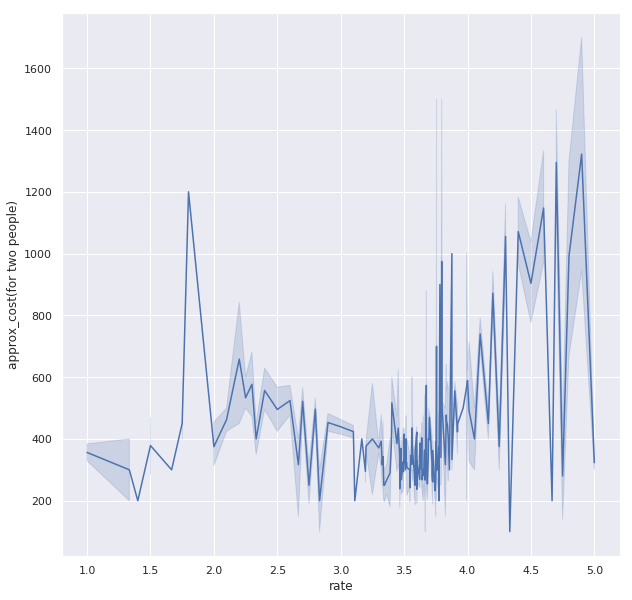

In [0]:
fig, ax = plt.subplots(figsize=(10,10))
sns.relplot(x="rate", y="approx_cost(for two people)", ax=ax, data=rest_df, kind="line")
plt.close(2)

### Line plot 2: VOTES vs APPROX_COST

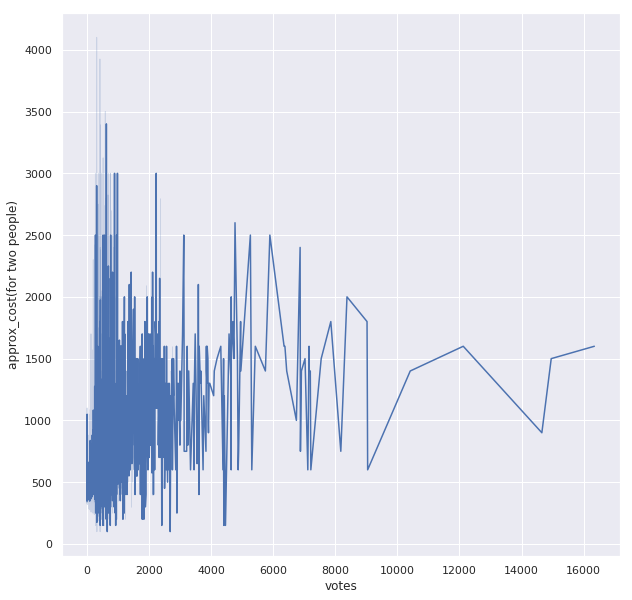

In [0]:
fig, ax = plt.subplots(figsize=(10,10))
sns.relplot(x="votes", y="approx_cost(for two people)", ax=ax, data=rest_df, kind="line")
plt.close(2)

In [0]:
rest_df["rate_votes_value_norm"] = rest_df["rate"]*rest_df["votes"]

In [0]:
rest_df["rate_votes_value_norm"] = rest_df["rate_votes_value_norm"]/max(rest_df["rate_votes_value_norm"])
rest_df["rate_votes_value_norm"]

0        0.039674
1        0.040288
2        0.043556
3        0.004065
4        0.007876
5        0.013570
6        0.000360
7        0.146804
8        0.016182
9        0.026430
10       0.020579
11       0.007866
12       0.008600
13       0.021176
15       0.004270
16       0.006476
17       0.006832
18       0.004529
19       0.000503
20       0.002322
21       0.008316
22       0.001259
23       0.002787
24       0.001432
25       0.000440
26       0.003558
27       0.000165
28       0.000948
29       0.007022
30       0.010938
           ...   
51540    0.000398
51542    0.000000
51552    0.000568
51555    0.000350
51556    0.000206
51563    0.000000
51566    0.000000
51567    0.000000
51568    0.000000
51569    0.000165
51571    0.000000
51572    0.000247
51573    0.000000
51577    0.000165
51578    0.000000
51579    0.000000
51584    0.000310
51587    0.000000
51595    0.000200
51606    0.048705
51607    0.012671
51610    0.000552
51611    0.002279
51614    0.000200
51620    0

### Line plot 3: RATE\*VOTES/MAX(RATE\*VOTES) vs APPROX_COST

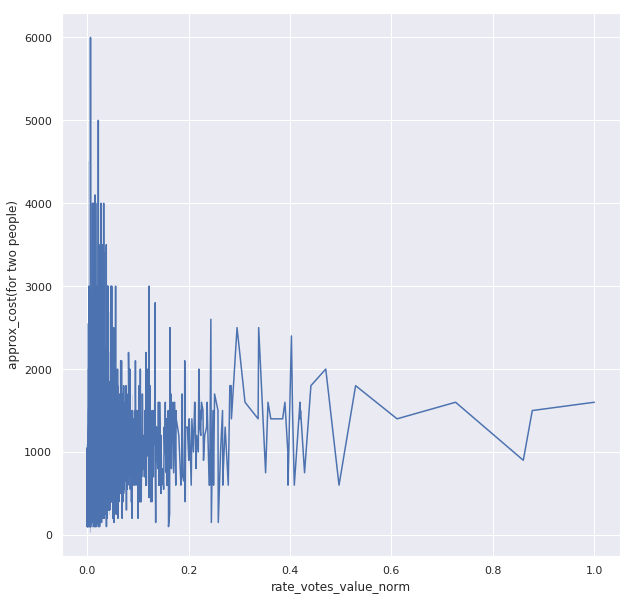

In [0]:
fig, ax = plt.subplots(figsize=(10,10))
sns.relplot(x="rate_votes_value_norm", y="approx_cost(for two people)", ax=ax, data=rest_df, kind="line")
plt.close(2)

### INFERENCE:
#### From the above line plots, we can infer that the columns "rate" and "votes" (number of people who rated) do not have a linear relationship with the target variable. Even rate and votes combined and normalized do not seem to be of value as they are non-linear with the target.  
#### We will not be dropping any columns because of this inference but for now, we suspect that linear regression might not be a good choice for this particular problem.
#### However, we are discarding "reviews_list" as it no longer serves our purpose.

In [0]:
rest_df.drop(["reviews_list"], axis=1, inplace=True)

### Find correlation between rates, votes and approx_cost(for two people) using Pearson's coefficient

In [0]:
# Checking the correlation of rate and votes with approx cost using Pearson's R
rate_viz_df = rest_df[['rate','votes','approx_cost(for two people)']]
correlation = rate_viz_df.corr(method='pearson')
correlation

,rate,votes,approx_cost(for two people)
rate,1.000000,0.301694,0.239840
votes,0.301694,1.000000,0.353345
approx_cost(for two people),0.239840,0.353345,1.000000


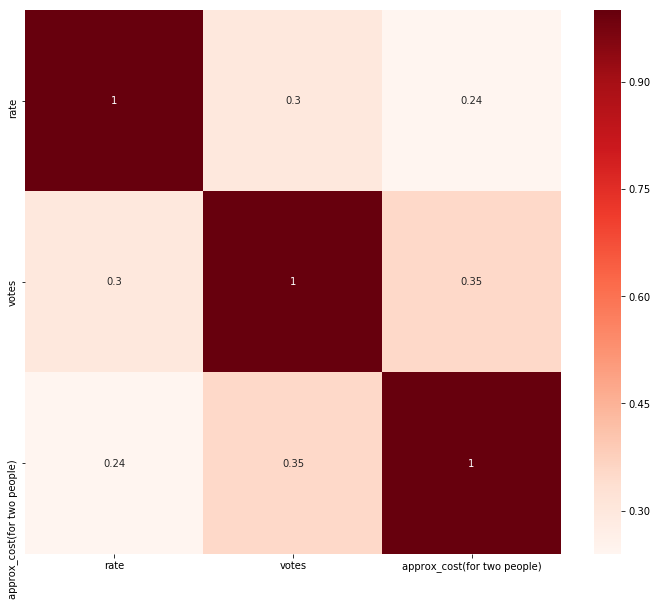

In [0]:
# Visualizing the correlation
plt.figure(figsize=(12,10))
sns.heatmap(correlation, annot=True, cmap=plt.cm.Reds)
plt.show()

### Like we suspected, there is no correlation between the approximate cost for 2 people and rate or votes.

## 2) d) Query to get the neighborhood with highest average rating

In [0]:
avg_rate_loc_df = rest_df.groupby("location")["rate"].mean().to_frame().reset_index()
avg_rate_loc_df[avg_rate_loc_df["rate"]==avg_rate_loc_df["rate"].max()]

,location,rate
51,Lavelle Road,4.09452


### Query to understand the characteristics of "Lavelle Road"

In [0]:
lavelle_road_df = rest_df[rest_df["location"]=="Lavelle Road"]
lavelle_road_df

,name,rate,votes,location,rest_type,cuisines,approx_cost(for two people),listed_in(type),rate_votes_value_norm
4981,JW Kitchen - JW Marriott Bengaluru,4.400000,2111,Lavelle Road,Fine Dining,"North Indian, Continental, Italian",2200,Buffet,0.115974
4987,Rasovara,4.300000,763,Lavelle Road,Casual Dining,"Rajasthani, North Indian",1400,Buffet,0.040965
4994,The Spice Bazaar,4.200000,347,Lavelle Road,"Casual Dining, Bar","North Indian, Mughlai",1000,Buffet,0.018197
4995,BBQ'D - Global Grill & Brewery,4.300000,471,Lavelle Road,"Casual Dining, Microbrewery","BBQ, North Indian",1500,Buffet,0.025288
5001,Cafe Mangii,4.300000,1048,Lavelle Road,Casual Dining,"Italian, Continental, Pizza",1600,Buffet,0.056266
5009,South Parade - The Chancery Hotel,3.100000,120,Lavelle Road,"Casual Dining, Bar","North Indian, Continental, Chinese",1200,Buffet,0.004645
5048,Glen's Bakehouse,4.400000,1084,Lavelle Road,"Bakery, Cafe","Bakery, Cafe, Italian, Desserts",600,Cafes,0.059553
5051,Bengaluru Baking Company - JW Marriott Bengaluru,4.300000,521,Lavelle Road,"Bakery, Cafe","Salad, Bakery, Cafe, Sandwich, Italian, Burger",1400,Cafes,0.027972
5070,The Blackboard Bakery,3.700000,91,Lavelle Road,"Cafe, Bakery","Cafe, Bakery, Continental",1000,Cafes,0.004204
5073,Fresh Pressery Cafe,4.100000,104,Lavelle Road,"Cafe, Quick Bites","Cafe, Italian, Healthy Food",1200,Cafes,0.005324


In [0]:
# To check the most popular restaurant types in Lavelle Road
lavelle_road_df.groupby("rest_type").count()["name"]

rest_type
Bakery                           2
Bakery, Cafe                     2
Bakery, Dessert Parlor           1
Bar                              1
Beverage Shop                    1
Beverage Shop, Dessert Parlor    1
Cafe                             2
Cafe, Bakery                     1
Cafe, Quick Bites                1
Casual Dining                    9
Casual Dining, Bar               9
Casual Dining, Irani Cafee       1
Casual Dining, Microbrewery      2
Confectionery                    1
Delivery                         1
Dessert Parlor                   3
Fine Dining                      5
Fine Dining, Lounge              1
Fine Dining, Microbrewery        1
Kiosk                            1
Lounge                           3
Pub                              1
Pub, Microbrewery                1
Quick Bites                      5
Name: name, dtype: int64

In [0]:
# To get the popular food choices offered in Lavelle Road
lavelle_road_df.groupby("cuisines").count()["name"]

cuisines
American, Finger Food                                                  1
Asian, Japanese, Thai                                                  2
Asian, North Indian, Continental                                       1
BBQ, North Indian                                                      1
Bakery                                                                 2
Bakery, Cafe, Italian, Desserts                                        1
Bakery, French, Desserts                                               1
Beverages, Fast Food                                                   1
Cafe                                                                   1
Cafe, Bakery, Continental                                              1
Cafe, Fast Food                                                        1
Cafe, Italian, Healthy Food                                            1
Chinese, Momos                                                         1
Continental                               

In [0]:
# To check the average price for 2 people in Lavelle Road
lavelle_road_df["approx_cost(for two people)"].mean()

1323.2142857142858

In [0]:
# To check the type of services available in Lavelle Road
lavelle_road_df.groupby("listed_in(type)").count()["name"]

listed_in(type)
Buffet       6
Cafes        6
Delivery    23
Desserts     3
Dine-out    18
Name: name, dtype: int64

### As we can see, Lavelle road is the neighborhood with the highest average rating (4.09/5). Most restaurants in Lavelle road offer delivery services and the average approximate cost for 2 people in Lavelle Road is 1323 rupees. Casual dining restaurants that have bars are predominantly more in this road and also, most of these restaurants provide desserts. 

In [0]:
# Dropping rows that have null values in rest_type
rest_df.dropna(subset=["rest_type"], inplace=True)

In [0]:
rest_df.shape

(12380, 9)

## WE HAVE USED THE CONCEPT FOR PICKLING FOR FUTURE USE. THIS SAVES THE TRAINED STATE OF A MODEL AND CAN ALWAYS BE RELOADED INTO THE PROGRAM WITHOUT HAVING TO TRAIN IT AGAIN.

In [0]:
def pickling(obj, filename):
  _ = f"../content/drive/My Drive/Data Science - 5901 - A1/{filename}.pkl"
  with open(_, "wb") as f:
    pkl.dump(obj, f)
    
def unpickling(filename):
  _ = f"../content/drive/My Drive/Data Science - 5901 - A1/{filename}.pkl"
  with open(_, "rb") as f:
    file_content = pkl.load(f)
  return file_content

In [0]:
# Pickle cleaned dataframe for future use
pickling(rest_df, "cleaned_rest_df")

In [0]:
# One-Hot encode location
rest_df = pd.concat([rest_df, pd.get_dummies(rest_df["location"], prefix="loc")], axis=1)
rest_df

,name,rate,votes,location,rest_type,cuisines,approx_cost(for two people),listed_in(type),rate_votes_value_norm,loc_BTM,loc_Banashankari,loc_Banaswadi,loc_Bannerghatta Road,loc_Basavanagudi,loc_Basaveshwara Nagar,loc_Bellandur,loc_Bommanahalli,loc_Brigade Road,loc_Brookefield,loc_CV Raman Nagar,loc_Central Bangalore,loc_Church Street,loc_City Market,loc_Commercial Street,loc_Cunningham Road,loc_Domlur,loc_East Bangalore,loc_Ejipura,loc_Electronic City,loc_Frazer Town,loc_HBR Layout,loc_HSR,loc_Hebbal,loc_Hennur,loc_Hosur Road,"loc_ITPL Main Road, Whitefield",loc_Indiranagar,loc_Infantry Road,loc_JP Nagar,loc_Jakkur,...,loc_Magadi Road,loc_Majestic,loc_Malleshwaram,loc_Marathahalli,loc_Mysore Road,loc_Nagarbhavi,loc_Nagawara,loc_New BEL Road,loc_North Bangalore,loc_Old Airport Road,loc_Old Madras Road,loc_Peenya,loc_RT Nagar,loc_Race Course Road,loc_Rajajinagar,loc_Rajarajeshwari Nagar,loc_Rammurthy Nagar,loc_Residency Road,loc_Richmond Road,loc_Sadashiv Nagar,loc_Sahakara Nagar,loc_Sanjay Nagar,loc_Sankey Road,loc_Sarjapur Road,loc_Seshadripuram,loc_Shanti Nagar,loc_Shivajinagar,loc_South Bangalore,loc_St. Marks Road,loc_Thippasandra,loc_Ulsoor,loc_Uttarahalli,"loc_Varthur Main Road, Whitefield",loc_Vasanth Nagar,loc_Vijay Nagar,loc_West Bangalore,loc_Whitefield,loc_Wilson Garden,loc_Yelahanka,loc_Yeshwantpur
0,Jalsa,4.100000,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800,Buffet,0.039674,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Spice Elephant,4.100000,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800,Buffet,0.040288,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,San Churro Cafe,3.800000,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800,Buffet,0.043556,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Addhuri Udupi Bhojana,3.700000,88,Banashankari,Quick Bites,"South Indian, North Indian",300,Buffet,0.004065,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Grand Village,3.800000,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600,Buffet,0.007876,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Timepass Dinner,3.800000,286,Basavanagudi,Casual Dining,North Indian,600,Buffet,0.013570,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Rosewood International Hotel - Bar & Restaurant,3.600000,8,Mysore Road,Casual Dining,"North Indian, South Indian, Andhra, Chinese",800,Buffet,0.000360,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Onesta,4.600000,2556,Banashankari,"Casual Dining, Cafe","Pizza, Cafe, Italian",600,Cafes,0.146804,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,Penthouse Cafe,4.000000,324,Banashankari,Cafe,"Cafe, Italian, Continental",700,Cafes,0.016182,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Smacznego,4.200000,504,Banashankari,Cafe,"Cafe, Mexican, Italian, Momos, Beverages",550,Cafes,0.026430,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Feature Transformation

#### There are certain features like location and rest_type which can be transformed to numerical values using encoding methods like One hot encoder or label encoder. For our use case, we are transforming location and rest_type using one hot encoder as the cardinality is not really huge. However, the cardinality of cuisines is really huge and that's why we are going with binary encoder.

In [0]:
# One-Hot encode rest_type
rest_df = pd.concat([rest_df, pd.get_dummies(rest_df["rest_type"], prefix="rt")], axis=1)
rest_df

,name,rate,votes,location,rest_type,cuisines,approx_cost(for two people),listed_in(type),rate_votes_value_norm,loc_BTM,loc_Banashankari,loc_Banaswadi,loc_Bannerghatta Road,loc_Basavanagudi,loc_Basaveshwara Nagar,loc_Bellandur,loc_Bommanahalli,loc_Brigade Road,loc_Brookefield,loc_CV Raman Nagar,loc_Central Bangalore,loc_Church Street,loc_City Market,loc_Commercial Street,loc_Cunningham Road,loc_Domlur,loc_East Bangalore,loc_Ejipura,loc_Electronic City,loc_Frazer Town,loc_HBR Layout,loc_HSR,loc_Hebbal,loc_Hennur,loc_Hosur Road,"loc_ITPL Main Road, Whitefield",loc_Indiranagar,loc_Infantry Road,loc_JP Nagar,loc_Jakkur,...,rt_Food Court,"rt_Food Court, Beverage Shop","rt_Food Court, Casual Dining","rt_Food Court, Dessert Parlor","rt_Food Court, Quick Bites",rt_Food Truck,rt_Kiosk,rt_Lounge,"rt_Lounge, Bar","rt_Lounge, Cafe","rt_Lounge, Casual Dining","rt_Lounge, Microbrewery",rt_Mess,"rt_Mess, Quick Bites",rt_Microbrewery,"rt_Microbrewery, Bar","rt_Microbrewery, Casual Dining","rt_Microbrewery, Lounge","rt_Microbrewery, Pub",rt_Pop Up,rt_Pub,"rt_Pub, Bar","rt_Pub, Cafe","rt_Pub, Casual Dining","rt_Pub, Microbrewery",rt_Quick Bites,"rt_Quick Bites, Bakery","rt_Quick Bites, Beverage Shop","rt_Quick Bites, Cafe","rt_Quick Bites, Dessert Parlor","rt_Quick Bites, Food Court","rt_Quick Bites, Kiosk","rt_Quick Bites, Meat Shop","rt_Quick Bites, Mess","rt_Quick Bites, Sweet Shop",rt_Sweet Shop,"rt_Sweet Shop, Dessert Parlor","rt_Sweet Shop, Quick Bites",rt_Takeaway,"rt_Takeaway, Delivery"
0,Jalsa,4.100000,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800,Buffet,0.039674,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Spice Elephant,4.100000,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800,Buffet,0.040288,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,San Churro Cafe,3.800000,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800,Buffet,0.043556,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Addhuri Udupi Bhojana,3.700000,88,Banashankari,Quick Bites,"South Indian, North Indian",300,Buffet,0.004065,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Grand Village,3.800000,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600,Buffet,0.007876,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Timepass Dinner,3.800000,286,Basavanagudi,Casual Dining,North Indian,600,Buffet,0.013570,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Rosewood International Hotel - Bar & Restaurant,3.600000,8,Mysore Road,Casual Dining,"North Indian, South Indian, Andhra, Chinese",800,Buffet,0.000360,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Onesta,4.600000,2556,Banashankari,"Casual Dining, Cafe","Pizza, Cafe, Italian",600,Cafes,0.146804,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,Penthouse Cafe,4.000000,324,Banashankari,Cafe,"Cafe, Italian, Continental",700,Cafes,0.016182,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Smacznego,4.200000,504,Banashankari,Cafe,"Cafe, Mexican, Italian, Momos, Beverages",550,Cafes,0.026430,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [0]:
# One-Hot encode listed_in_type
rest_df = pd.concat([rest_df, pd.get_dummies(rest_df["listed_in(type)"], prefix="listed_in")], axis=1)
rest_df

,name,rate,votes,location,rest_type,cuisines,approx_cost(for two people),listed_in(type),rate_votes_value_norm,loc_BTM,loc_Banashankari,loc_Banaswadi,loc_Bannerghatta Road,loc_Basavanagudi,loc_Basaveshwara Nagar,loc_Bellandur,loc_Bommanahalli,loc_Brigade Road,loc_Brookefield,loc_CV Raman Nagar,loc_Central Bangalore,loc_Church Street,loc_City Market,loc_Commercial Street,loc_Cunningham Road,loc_Domlur,loc_East Bangalore,loc_Ejipura,loc_Electronic City,loc_Frazer Town,loc_HBR Layout,loc_HSR,loc_Hebbal,loc_Hennur,loc_Hosur Road,"loc_ITPL Main Road, Whitefield",loc_Indiranagar,loc_Infantry Road,loc_JP Nagar,loc_Jakkur,...,rt_Lounge,"rt_Lounge, Bar","rt_Lounge, Cafe","rt_Lounge, Casual Dining","rt_Lounge, Microbrewery",rt_Mess,"rt_Mess, Quick Bites",rt_Microbrewery,"rt_Microbrewery, Bar","rt_Microbrewery, Casual Dining","rt_Microbrewery, Lounge","rt_Microbrewery, Pub",rt_Pop Up,rt_Pub,"rt_Pub, Bar","rt_Pub, Cafe","rt_Pub, Casual Dining","rt_Pub, Microbrewery",rt_Quick Bites,"rt_Quick Bites, Bakery","rt_Quick Bites, Beverage Shop","rt_Quick Bites, Cafe","rt_Quick Bites, Dessert Parlor","rt_Quick Bites, Food Court","rt_Quick Bites, Kiosk","rt_Quick Bites, Meat Shop","rt_Quick Bites, Mess","rt_Quick Bites, Sweet Shop",rt_Sweet Shop,"rt_Sweet Shop, Dessert Parlor","rt_Sweet Shop, Quick Bites",rt_Takeaway,"rt_Takeaway, Delivery",listed_in_Buffet,listed_in_Cafes,listed_in_Delivery,listed_in_Desserts,listed_in_Dine-out,listed_in_Drinks & nightlife,listed_in_Pubs and bars
0,Jalsa,4.100000,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800,Buffet,0.039674,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,Spice Elephant,4.100000,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800,Buffet,0.040288,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,San Churro Cafe,3.800000,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800,Buffet,0.043556,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,Addhuri Udupi Bhojana,3.700000,88,Banashankari,Quick Bites,"South Indian, North Indian",300,Buffet,0.004065,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,Grand Village,3.800000,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600,Buffet,0.007876,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,Timepass Dinner,3.800000,286,Basavanagudi,Casual Dining,North Indian,600,Buffet,0.013570,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6,Rosewood International Hotel - Bar & Restaurant,3.600000,8,Mysore Road,Casual Dining,"North Indian, South Indian, Andhra, Chinese",800,Buffet,0.000360,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7,Onesta,4.600000,2556,Banashankari,"Casual Dining, Cafe","Pizza, Cafe, Italian",600,Cafes,0.146804,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
8,Penthouse Cafe,4.000000,324,Banashankari,Cafe,"Cafe, Italian, Continental",700,Cafes,0.016182,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
9,Smacznego,4.200000,504,Banashankari,Cafe,"Cafe, Mexican, Italian, Momos, Beverages",550,Cafes,0.026430,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [0]:
# Binary encode cuisines
be = ce.BinaryEncoder(cols=["cuisines"])

In [0]:
rest_df = be.fit_transform(rest_df)
rest_df

,name,rate,votes,location,rest_type,cuisines_0,cuisines_1,cuisines_2,cuisines_3,cuisines_4,cuisines_5,cuisines_6,cuisines_7,cuisines_8,cuisines_9,cuisines_10,cuisines_11,cuisines_12,approx_cost(for two people),listed_in(type),rate_votes_value_norm,loc_BTM,loc_Banashankari,loc_Banaswadi,loc_Bannerghatta Road,loc_Basavanagudi,loc_Basaveshwara Nagar,loc_Bellandur,loc_Bommanahalli,loc_Brigade Road,loc_Brookefield,loc_CV Raman Nagar,loc_Central Bangalore,loc_Church Street,loc_City Market,loc_Commercial Street,loc_Cunningham Road,loc_Domlur,loc_East Bangalore,loc_Ejipura,...,rt_Lounge,"rt_Lounge, Bar","rt_Lounge, Cafe","rt_Lounge, Casual Dining","rt_Lounge, Microbrewery",rt_Mess,"rt_Mess, Quick Bites",rt_Microbrewery,"rt_Microbrewery, Bar","rt_Microbrewery, Casual Dining","rt_Microbrewery, Lounge","rt_Microbrewery, Pub",rt_Pop Up,rt_Pub,"rt_Pub, Bar","rt_Pub, Cafe","rt_Pub, Casual Dining","rt_Pub, Microbrewery",rt_Quick Bites,"rt_Quick Bites, Bakery","rt_Quick Bites, Beverage Shop","rt_Quick Bites, Cafe","rt_Quick Bites, Dessert Parlor","rt_Quick Bites, Food Court","rt_Quick Bites, Kiosk","rt_Quick Bites, Meat Shop","rt_Quick Bites, Mess","rt_Quick Bites, Sweet Shop",rt_Sweet Shop,"rt_Sweet Shop, Dessert Parlor","rt_Sweet Shop, Quick Bites",rt_Takeaway,"rt_Takeaway, Delivery",listed_in_Buffet,listed_in_Cafes,listed_in_Delivery,listed_in_Desserts,listed_in_Dine-out,listed_in_Drinks & nightlife,listed_in_Pubs and bars
0,Jalsa,4.100000,775,Banashankari,Casual Dining,0,0,0,0,0,0,0,0,0,0,0,0,1,800,Buffet,0.039674,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,Spice Elephant,4.100000,787,Banashankari,Casual Dining,0,0,0,0,0,0,0,0,0,0,0,1,0,800,Buffet,0.040288,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,San Churro Cafe,3.800000,918,Banashankari,"Cafe, Casual Dining",0,0,0,0,0,0,0,0,0,0,0,1,1,800,Buffet,0.043556,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,Addhuri Udupi Bhojana,3.700000,88,Banashankari,Quick Bites,0,0,0,0,0,0,0,0,0,0,1,0,0,300,Buffet,0.004065,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,Grand Village,3.800000,166,Basavanagudi,Casual Dining,0,0,0,0,0,0,0,0,0,0,1,0,1,600,Buffet,0.007876,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,Timepass Dinner,3.800000,286,Basavanagudi,Casual Dining,0,0,0,0,0,0,0,0,0,0,1,1,0,600,Buffet,0.013570,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6,Rosewood International Hotel - Bar & Restaurant,3.600000,8,Mysore Road,Casual Dining,0,0,0,0,0,0,0,0,0,0,1,1,1,800,Buffet,0.000360,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7,Onesta,4.600000,2556,Banashankari,"Casual Dining, Cafe",0,0,0,0,0,0,0,0,0,1,0,0,0,600,Cafes,0.146804,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
8,Penthouse Cafe,4.000000,324,Banashankari,Cafe,0,0,0,0,0,0,0,0,0,1,0,0,1,700,Cafes,0.016182,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
9,Smacznego,4.200000,504,Banashankari,Cafe,0,0,0,0,0,0,0,0,0,1,0,1,0,550,Cafes,0.026430,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


## 3) a) Since the dataset comprises the target or dependent variable along with the other attributes, this is a supervised learning problem. Also, the dependent variable consists of a continuous range of values, and hence we have approached this problem as a regression task.

## 3) b) We would choose the following models to test our dataset:

- Linear Regression (Since this is a regression problem, linear regression is an automatic choice although there are certain variables that do not have a linear relationship with the independent variable. )
- XGBoost (XGBoost is a type of boosting algorithm which can be used for this regression problem. This is a tree-based algorithm and it is an ensemble-based method. An ensemble-based model consists of several learners [models] and the prediction comes from a combination of all these learners. The main idea behind XGBoost is to boost the weak learners using gradient descent. And generally tree-based regression models run well on non-linear data and thus, we choose to go with this algorithm. Also, this has high speed and performance due to its optimization techniques for both software and hardware. )
- Random Forests (This algorithm is also based on trees and an ensemble-based method. The key difference between Random Forests and XGBoost is Random Forests algorithm depends on Bagging. Bagging is a type of technique where a selected number of features are taken at random while predicting the outcome. Random Forest Regressors are widely used for regression problems as they handle non-linear data pretty well.)
- Multi Layer Perceptrons (This is a neural network based algorithm which generally performs well on both type of problems - classification and regression. The reason we are using this is because certain attributes seem to be non-linear with the target and MLPs generally tend to work well on non-linear data. )
- Support Vector Regression (This can be a good model for regression because this model tries to take into account only the data points that produce the least error rate. Thus, the possibilities of achieving a better learning fit using this model is high.)

## 3) c) Evaluation metric used in this assignment:

We would be using these metrics to evaluate the performance of our models:
- MSE(Mean Squared Error)
- MAE(Mean Absolute Error)
- R^2(R Squared)

#### However, we will be focusing on r2 score and mean squared error values as both mean absolute error and mean squared error are fairly similar to each other.
 
 
#### Mean Squared error gives the average squared difference between the actual and the predicted values of the model. It suggests that smaller the mean squared error, the model is more efficient in finding the best fitting line.
 
#### R2 score explains the variance between the dependent and the independent variables of the dataset. The r2 score closer to 1 indicates that the data will fit the model better.



## 3) d) Avoiding overfitting:

We are avoiding overfitting by following a few steps:

- In case of linear regression models, we are not training the model with all the attributes and feature selection will help us in avoiding overfitting. 
- In case of tree-based regression models, we plan to avoid overfitting by specifying the minimum number of instances that must be present in a leaf for a split and also the maximum depth of a tree (prepruning techniques).
- We also plan to detect overfitting by performing tehcniques like holdout evaluation and K-fold cross validation. If the model fits the training data too well and doesn't generalize across testing data, we can suspect overfitting.

In [0]:
rest_df_duplicate = rest_df.copy()

In [0]:
# Retaining the encoded columns (given in the assignment) for training and testing
rest_df_final = rest_df.drop(["name", "votes", "rate_votes_value_norm", "location", "rest_type", "listed_in(type)", "listed_in_Buffet", "listed_in_Cafes",	"listed_in_Delivery",	"listed_in_Desserts",	"listed_in_Dine-out",	"listed_in_Drinks & nightlife",	"listed_in_Pubs and bars"], axis=1)
#rest_df_final = rest_df.drop(["name", "votes", "rate", "rate_votes_value_norm", "location", "listed_in_Buffet", "listed_in_Cafes",	"listed_in_Delivery",	"listed_in_Desserts",	"listed_in_Dine-out",	"listed_in_Drinks & nightlife",	"listed_in_Pubs and bars", "rest_type", "reviews_list", "listed_in(type)", "cuisines_0",	"cuisines_1",	"cuisines_2",	"cuisines_3",	"cuisines_4",	"cuisines_5",	"cuisines_6",	"cuisines_7",	"cuisines_8", "cuisines_9",	"cuisines_10", "cuisines_11",	"cuisines_12"], axis=1)

In [0]:
rest_df_final.shape

(12380, 201)

In [0]:
pickling(rest_df_final, "rest_df_final")

In [0]:
rest_df_final = unpickling("rest_df_final")

### Separating the target variable from the independent/input variables

In [0]:
X = rest_df_final.loc[:, rest_df_final.columns!="approx_cost(for two people)"]
y = rest_df_final.loc[:, rest_df_final.columns=="approx_cost(for two people)"]

### Splitting the dataset into train and test (8:2)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

## Training the models with initial parameters to get the best model and fine tuning them later 

## Linear Regression:

In [0]:
lr = LinearRegression(n_jobs=-1)

In [0]:
# Fitting the linear model using training data
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

### Linear Regression Model's predictions on training data

In [0]:
# Testing the model against training data
y_train_lr_pred = lr.predict(X_train)

In [0]:
linear_mse = mean_squared_error(y_train, y_train_lr_pred)
linear_mae = mean_absolute_error(y_train, y_train_lr_pred)
linear_r2 = r2_score(y_train, y_train_lr_pred)
print(f"Mean Squared Error: {linear_mse}")
print(f"Mean Absolute Error: {linear_mae}")
print(f"R2 Score: {linear_r2}")

Mean Squared Error: 41051.87861452858
Mean Absolute Error: 137.85503329522004
R2 Score: 0.7202165848934199


## XGBoost:

In [0]:
xgbm = xgb.XGBRegressor()

In [0]:
# Fitting the xgb regressor model using training data
xgbm.fit(X_train, y_train)

[18:04:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

### XGB Regressor's predictions on training data

In [0]:
# Testing the model against training data
y_train_xgbm_pred = xgbm.predict(X_train)

In [0]:
xgbm_mse = mean_squared_error(y_train, y_train_xgbm_pred)
xgbm_mae = mean_absolute_error(y_train, y_train_xgbm_pred)
xgbm_r2 = r2_score(y_train, y_train_xgbm_pred)
print(f"Mean Squared Error: {xgbm_mse}")
print(f"Mean Absolute Error: {xgbm_mae}")
print(f"R2 Score: {xgbm_r2}")

Mean Squared Error: 41774.99953826182
Mean Absolute Error: 140.05396920606276
R2 Score: 0.7152882540007744


## Random Forest:

In [0]:
rf = RandomForestRegressor()

In [0]:
# Fitting the random forest regressor model using training data
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

### Random Forests' predictions on training data

In [0]:
# Testing the model against training data
y_train_rf_pred = rf.predict(X_train)

In [0]:
rf_mse = mean_squared_error(y_train, y_train_rf_pred)
rf_mae = mean_absolute_error(y_train, y_train_rf_pred)
rf_r2 = r2_score(y_train, y_train_rf_pred)
print(f"Mean Squared Error: {rf_mse}")
print(f"Mean Absolute Error: {rf_mae}")
print(f"R2 Score: {rf_r2}")

Mean Squared Error: 8790.763813074256
Mean Absolute Error: 55.828120708888584
R2 Score: 0.9400877620215213


## Support Vector Regression:

In [0]:
svr = SVR()

In [0]:
# Fitting the SVR model using training data
svr.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

### SVR's predictions on training data

In [0]:
# Testing against training data
y_train_svr_pred = svr.predict(X_train)

In [0]:
svr_mse = mean_squared_error(y_train, y_train_svr_pred)
svr_mae = mean_absolute_error(y_train, y_train_svr_pred)
svr_r2 = r2_score(y_train, y_train_svr_pred)
print(f"Mean Squared Error: {svr_mse}")
print(f"Mean Absolute Error: {svr_mae}")
print(f"R2 Score: {svr_r2}")

Mean Squared Error: 149809.10228228962
Mean Absolute Error: 222.23798479599193
R2 Score: -0.021003268672733055


## Multilayer Perceptron:

In [0]:
mlp = MLPRegressor()

In [0]:
# Fitting the MLP model using training data
mlp.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

### MLP's predictions on training data

In [0]:
# Testing against training data
y_train_mlp_pred = mlp.predict(X_train)

In [0]:
mlp_mse = mean_squared_error(y_train, y_train_mlp_pred)
mlp_mae = mean_absolute_error(y_train, y_train_mlp_pred)
mlp_r2 = r2_score(y_train, y_train_mlp_pred)
print(f"Mean Squared Error: {mlp_mse}")
print(f"Mean Absolute Error: {mlp_mae}")
print(f"R2 Score: {mlp_r2}")

Mean Squared Error: 41508.41798418752
Mean Absolute Error: 138.6566150941897
R2 Score: 0.7171051038044989


## 3) e) Plotting the evaluation metrics for all the models tested against training data

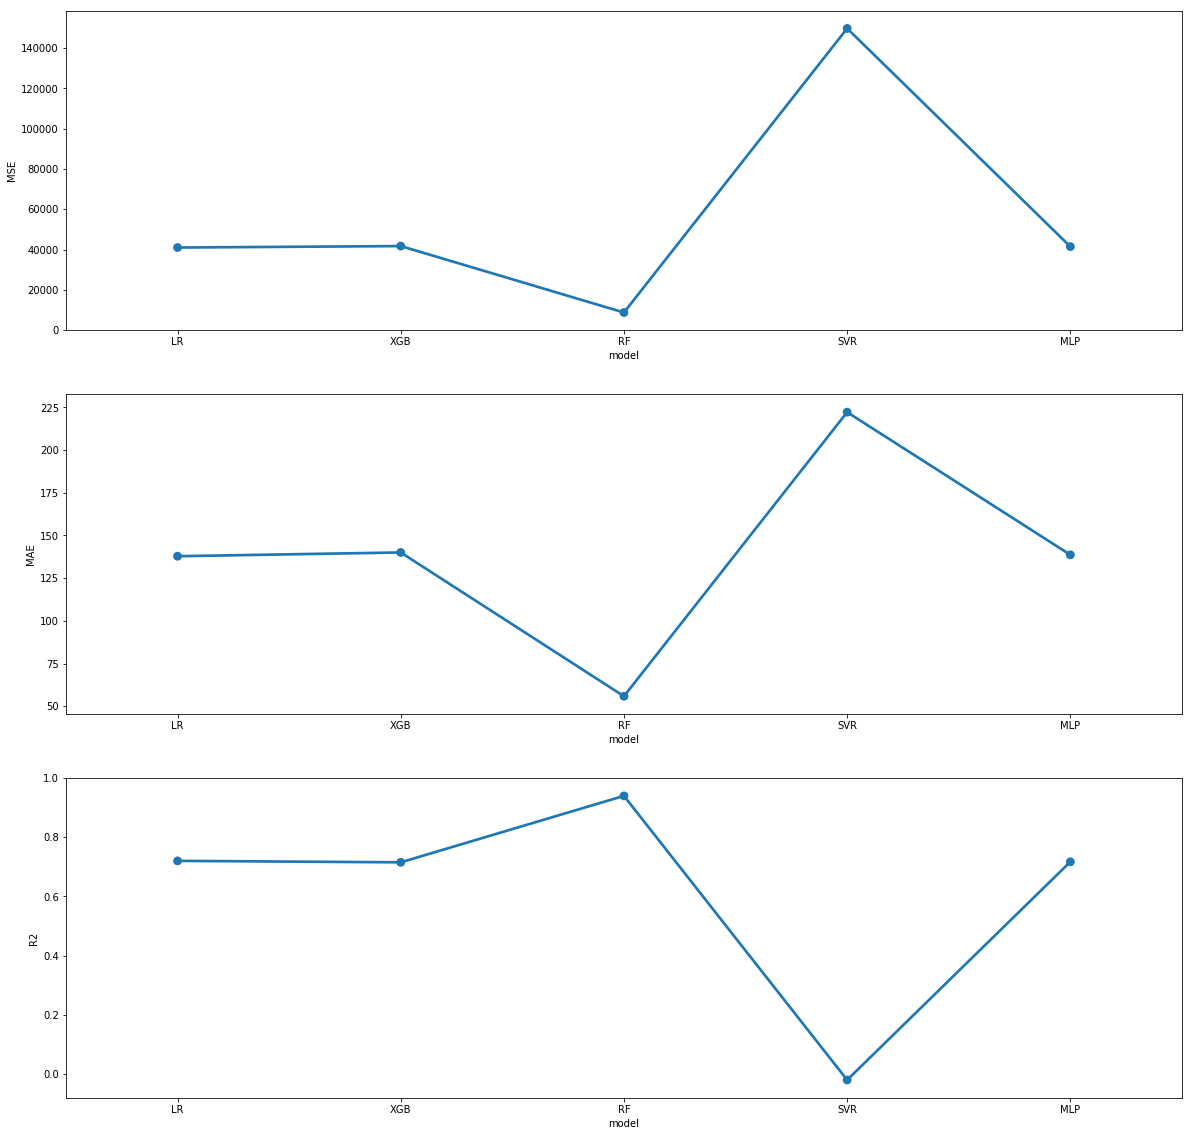

In [0]:
metrics = ["MSE", "MAE", "R2"]
metric_params = {
    "MSE": [
            {"model": "LR", "MSE": linear_mse}, 
            {"model": "XGB", "MSE": xgbm_mse}, 
            {"model": "RF", "MSE":rf_mse}, 
            {"model": "SVR", "MSE": svr_mse}, 
            {"model": "MLP", "MSE": mlp_mse}
           ],
    "MAE": [
            {"model": "LR", "MAE": linear_mae}, 
            {"model": "XGB", "MAE": xgbm_mae}, 
            {"model": "RF", "MAE":rf_mae}, 
            {"model": "SVR", "MAE": svr_mae}, 
            {"model": "MLP", "MAE": mlp_mae}
           ],
    "R2": [
            {"model": "LR", "R2": linear_r2}, 
            {"model": "XGB", "R2": xgbm_r2}, 
            {"model": "RF", "R2":rf_r2}, 
            {"model": "SVR", "R2": svr_r2}, 
            {"model": "MLP", "R2": mlp_r2}
          ]
}
fig, axes = plt.subplots(3, 1, figsize=(20,20))
for i, metric in enumerate(metrics):
  df = pd.DataFrame(metric_params[metric])
  sns.catplot(x="model", y=metric, data=df, kind="point", ax=axes[i])
  plt.close(2)

### 3) e) Initially, we are using the holdout approach as we want to build a model and test it both on training and testing data. This would enable us to test the same model across both types of data (train and test) whereas k-fold cross validation on training and testing data separately might not make sense and does not provide us with one model that we can use on the train test splits. This is because internally k models are built and only the scores are given in the end. However, we would also be using k-fold cross validation later as it gives us a more generalized model and it has been explained detailly in the later section.

### On hold out evaluation, we can see that all the algorithms perform pretty decently with Random Forests performing exceptionally well. This is not a good sign as this might mean that Random Forests is getting biased towards training data. 

## 3) f) Plotting the evaluation metrics for all the models tested against testing data

### Linear Regression's predictions on testing data

In [0]:
# Predicting using the linear model
y_pred = lr.predict(X_test)

In [0]:
linear_test_mse = mean_squared_error(y_test, y_pred)
linear_test_mae = mean_absolute_error(y_test, y_pred)
linear_test_r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {linear_test_mse}")
print(f"Mean Absolute Error: {linear_test_mae}")
print(f"R2 Score: {linear_test_r2}")

Mean Squared Error: 9.931616570827042e+21
Mean Absolute Error: 4905805092.855283
R2 Score: -5.525351142049564e+16


### XGB Regressor's predictions on testing data

In [0]:
# Predicting using the XGboost model
y_test_xgbm_pred = xgbm.predict(X_test)

In [0]:
xgbm_test_mse = mean_squared_error(y_test, y_test_xgbm_pred)
xgbm_test_mae = mean_absolute_error(y_test, y_test_xgbm_pred)
xgbm_test_r2 = r2_score(y_test, y_test_xgbm_pred)
print(f"Mean Squared Error: {xgbm_test_mse}")
print(f"Mean Absolute Error: {xgbm_test_mae}")
print(f"R2 Score: {xgbm_test_r2}")

Mean Squared Error: 54379.968788277896
Mean Absolute Error: 148.58477185423425
R2 Score: 0.6974627237105371


### Random Forests' predictions on testing data

In [0]:
# Predicting using the Random forest model
y_test_rf_pred = rf.predict(X_test)

In [0]:
rf_test_mse = mean_squared_error(y_test, y_test_rf_pred)
rf_test_mae = mean_absolute_error(y_test, y_test_rf_pred)
rf_test_r2 = r2_score(y_test, y_test_rf_pred)
print(f"Mean Squared Error: {rf_test_mse}")
print(f"Mean Absolute Error: {rf_test_mae}")
print(f"R2 Score: {rf_test_r2}")


Mean Squared Error: 47015.161892026576
Mean Absolute Error: 135.0083896974951
R2 Score: 0.7384360576134066


### SVR's predictions on testing data

In [0]:
# Predicting using the SVR model
y_test_svr_pred = svr.predict(X_test)

In [0]:
svr_test_mse = mean_squared_error(y_test, y_test_svr_pred)
svr_test_mae = mean_absolute_error(y_test, y_test_svr_pred)
svr_test_r2 = r2_score(y_test, y_test_svr_pred)
print(f"Mean Squared Error: {svr_test_mse}")
print(f"Mean Absolute Error: {svr_test_mae}")
print(f"R2 Score: {svr_test_r2}")

Mean Squared Error: 183239.27789459864
Mean Absolute Error: 228.09667203617735
R2 Score: -0.019432582966648626


### MLP's predictions on testing data

In [0]:
# Predicting using the MLP model
y_test_mlp_pred = mlp.predict(X_test)

In [0]:
mlp_test_mse = mean_squared_error(y_test, y_test_mlp_pred)
mlp_test_mae = mean_absolute_error(y_test, y_test_mlp_pred)
mlp_test_r2 = r2_score(y_test, y_test_mlp_pred)
print(f"Mean Squared Error: {mlp_test_mse}")
print(f"Mean Absolute Error: {mlp_test_mae}")
print(f"R2 Score: {mlp_test_r2}")

Mean Squared Error: 50227.37612569967
Mean Absolute Error: 143.46442286404093
R2 Score: 0.7205652392446547


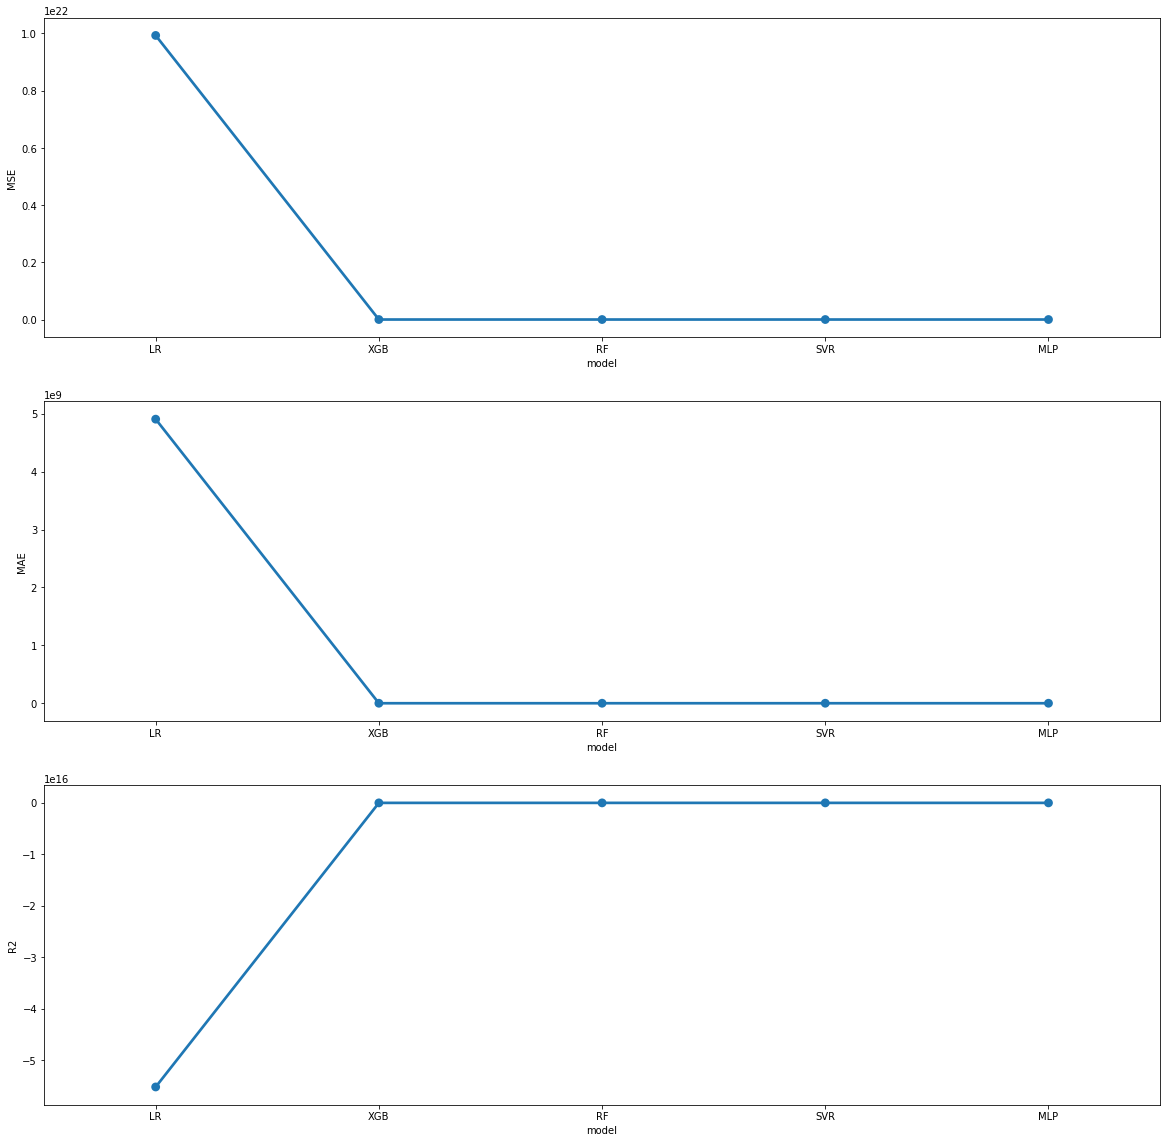

In [0]:
metrics = ["MSE", "MAE", "R2"]
metric_params = {
    "MSE": [
            {"model": "LR", "MSE": linear_test_mse}, 
            {"model": "XGB", "MSE": xgbm_test_mse}, 
            {"model": "RF", "MSE":rf_test_mse}, 
            {"model": "SVR", "MSE": svr_test_mse}, 
            {"model": "MLP", "MSE": mlp_test_mse}
           ],
    "MAE": [
            {"model": "LR", "MAE": linear_test_mae}, 
            {"model": "XGB", "MAE": xgbm_test_mae}, 
            {"model": "RF", "MAE":rf_test_mae}, 
            {"model": "SVR", "MAE": svr_test_mae}, 
            {"model": "MLP", "MAE": mlp_test_mae}
           ],
    "R2": [
            {"model": "LR", "R2": linear_test_r2}, 
            {"model": "XGB", "R2": xgbm_test_r2}, 
            {"model": "RF", "R2":rf_test_r2}, 
            {"model": "SVR", "R2": svr_test_r2}, 
            {"model": "MLP", "R2": mlp_test_r2}
          ]
}
fig, axes = plt.subplots(3, 1, figsize=(20,20))
for i, metric in enumerate(metrics):
  df = pd.DataFrame(metric_params[metric])
  sns.catplot(x="model", y=metric, data=df, kind="point", ax=axes[i])
  plt.close(2)

### Linear Regression performs very badly on testing data as the dataset is non-linear in nature. This is affecting the plotting of other algorithms as well. So in the following plot, we are removing the Linear Regression algorithm's value for these 3 metrics.

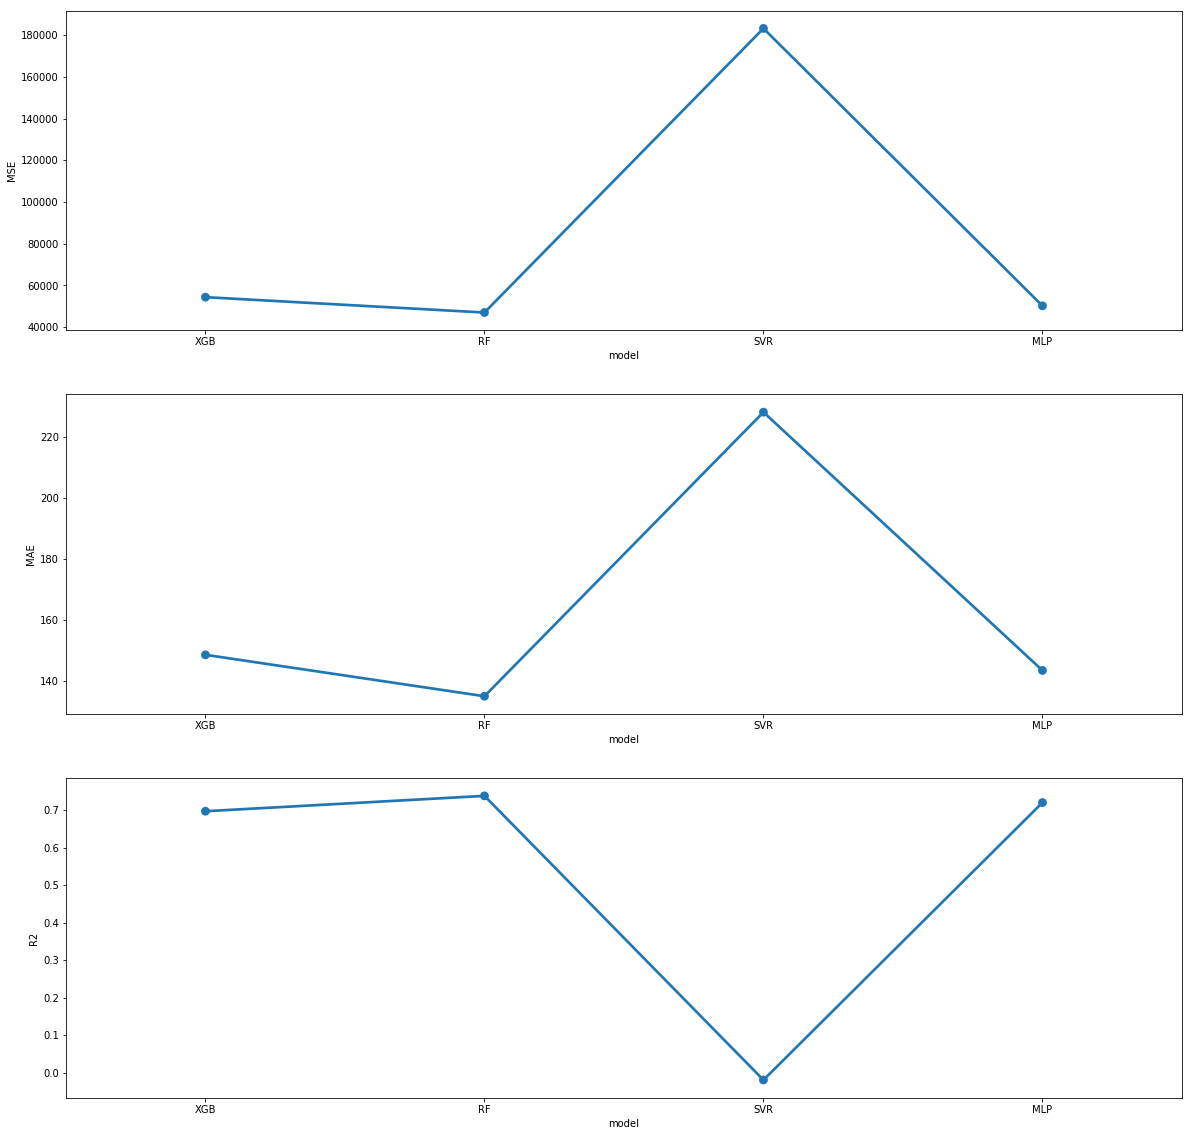

In [0]:
metrics = ["MSE", "MAE", "R2"]
metric_params = {
    "MSE": [
            #{"model": "LR", "MSE": linear_test_mse}, 
            {"model": "XGB", "MSE": xgbm_test_mse}, 
            {"model": "RF", "MSE":rf_test_mse}, 
            {"model": "SVR", "MSE": svr_test_mse}, 
            {"model": "MLP", "MSE": mlp_test_mse}
           ],
    "MAE": [
            #{"model": "LR", "MAE": linear_test_mae}, 
            {"model": "XGB", "MAE": xgbm_test_mae}, 
            {"model": "RF", "MAE":rf_test_mae}, 
            {"model": "SVR", "MAE": svr_test_mae}, 
            {"model": "MLP", "MAE": mlp_test_mae}
           ],
    "R2": [
            #{"model": "LR", "R2": linear_test_r2}, 
            {"model": "XGB", "R2": xgbm_test_r2}, 
            {"model": "RF", "R2":rf_test_r2}, 
            {"model": "SVR", "R2": svr_test_r2}, 
            {"model": "MLP", "R2": mlp_test_r2}
          ]
}
fig, axes = plt.subplots(3, 1, figsize=(20,20))
for i, metric in enumerate(metrics):
  df = pd.DataFrame(metric_params[metric])
  sns.catplot(x="model", y=metric, data=df, kind="point", ax=axes[i])
  plt.close(2)

### 3) f) As you can clearly see from the above two plots for the model performance on training and testing data, the MSE is very high on testing data for Linear Regression. MSE is a metric that is used to magnify and penalize the magnitude of wrong predictions. The r2 score of Linear Regression as well suggests that the data is non-linear as it is on the negative end. Also, Random Forests seem to perform really well on training data while it is on par with the other algorithms when it comes to testing data. The MSE of Random Forests is not pretty high on testing data, and the r2 score as well is around 0.67 which suggests this can be a good model. MLP and XGBoost more or less perform consistently across training and testing. The MSE and r2 score is pretty decent and since the performance is more generalized, these models avoid overfitting. The r2 score of SVR is in negative and the MSE is large compared to the other models except LR and this can be a bad sign. Thus, SVR and LR models are out of contention.

### Now, we plan to go ahead with k-fold cross validation approach on the Random Forest, XGBoost and MLP models to find the best model and tune its hyperparameters. This gives us the opportunity to come up with a metric that allows us to explore the whole dataset by interchanging various partitions of the dataset for training and testing. This allows us to evaluate a more generalized model as we generate k different models and measure the performance across all. Also, in case of 1-fold cross validation, we simply split the data into two parts - training and testing (say 8:2 split) and one cannot really say if the model has generalized well and this avoids overfitting.

## K-fold Cross Validation for XGBoost, RF and MLP

## MLP Regressor

In [0]:
kmlp = MLPRegressor()
scores = cross_validate(kmlp, X, y, scoring=["r2", "neg_mean_squared_error"], cv=5)

In [0]:
print("Mean_MSE: {}\nStd_MSE: {}\nMean_r2: {}\nStd_r2: {}".format(
          scores["test_neg_mean_squared_error"].mean(),
          scores["test_neg_mean_squared_error"].std(),
          scores["test_r2"].mean(),
          scores["test_r2"].std()
))

Mean_MSE: -55279.52740727896
Std_MSE: 13943.786801427665
Mean_r2: 0.5952996953502863
Std_r2: 0.11357483881662365


## Random Forest Regressor

In [0]:
krf = RandomForestRegressor()
scores = cross_validate(krf, X, y, scoring=["r2", "neg_mean_squared_error"], cv=5)

In [0]:
print("Mean_MSE: {}\nStd_MSE: {}\nMean_r2: {}\nStd_r2: {}".format(
          scores["test_neg_mean_squared_error"].mean(),
          scores["test_neg_mean_squared_error"].std(),
          scores["test_r2"].mean(),
          scores["test_r2"].std()
))

Mean_MSE: -48807.82061930493
Std_MSE: 18759.182190621555
Mean_r2: 0.6640455472723594
Std_r2: 0.04689049187589179


## XGBoost Regressor

In [0]:
kxgb = xgb.XGBRegressor()
scores = cross_validate(kxgb, X, y, scoring=["r2", "neg_mean_squared_error"], cv=5)

[18:14:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:14:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:15:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:15:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:15:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
print("Mean_MSE: {}\nStd_MSE: {}\nMean_r2: {}\nStd_r2: {}".format(
          scores["test_neg_mean_squared_error"].mean(),
          scores["test_neg_mean_squared_error"].std(),
          scores["test_r2"].mean(),
          scores["test_r2"].std()
))

Mean_MSE: -51550.35341447308
Std_MSE: 20180.54602044853
Mean_r2: 0.646068733198516
Std_r2: 0.049271509837075074


### From the above k-fold cross validation mean and standard deviation scores, we can see that Random Forests algorithm is the best. In RF Regressor, the standard deviation is less and this means that model is generalizing well across all the folds whereas the r2 score is also pretty high. Although XGBoost comes close, we are going with Random Forests as it is slightly better.

## 3) g) Hyperparameter tuning

### 3) g) Yes, we believe we can make the model perform better by tuning its hyperparameters. Hyperparameters are parameters that are external to the model, they are not derived from the model but are rather specified by the developer. Since the model was earlier built using the default hyperparameters given in sklearn package, we want to find the best combination of hyperparameters that will give us the best result. Hence, we are tuning the hyperparameters by using a technique called as GridSearchCV. This is provided by sklearn. GridSearchCV is initially given all the possible set of hyperparameters. After this step, it performs a k-fold cross validation internally for each possible combination of hyperparameters. Thus, it evaluates each possible combination and gives us the combination of hyperparameters that scored the best while cross validating.

In [0]:
print(f"Start time: {datetime.now()}")
# Random Forest Regressor
rf_parameters = {'n_estimators':[80,100,110], 'criterion':['mse'], 
                  'max_depth':[35,40], 'min_samples_leaf':[1,3],
                  'min_samples_split':[3,5]}
rf_gsc = GridSearchCV(estimator=RandomForestRegressor(), param_grid=rf_parameters,
                       scoring='r2', cv=8, n_jobs=-1)
grid_result = rf_gsc.fit(X_train, y_train)
rf_best_params = grid_result.best_params_
print(f"End time: {datetime.now()}")
rf_best_params

Start time: 2019-07-01 20:27:22.095842
End time: 2019-07-01 20:46:33.093471


{'criterion': 'mse',
 'max_depth': 35,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 110}

In [0]:
grid_result.best_score_

0.7229550436735622

In [0]:
# Running the best params on test data
rf_best = RandomForestRegressor(n_estimators=110, max_depth=35, min_samples_leaf=1, min_samples_split=5, criterion="mse")
rf_best.fit(X_train, y_train)
y_final_pred = rf_best.predict(X_test)

print("R2 Score: {}".format(r2_score(y_test, y_final_pred)))
print("MSE: {}".format(mean_squared_error(y_test, y_final_pred)))

R2 Score: 0.7493373983637219
MSE: 45055.685767222225


### INFERENCE:
#### We can see that using the best hyperparameters given by Grid Search, the r2 score has increased from 0.66 to 0.75 and the MSE has come down from 48807 to 45055. GridSearchCV has increased the model performance significantly. The number of decision trees built in this ensemble method is 110. Generally, a good number for the number of estimators for a random forest algorithm is square root of the number of records. In this case, this holds true. The maximum depth of a tree is 35, which means the trees are not built upto the last level. The minimum samples required in a node for it to be further split is 5 whereas the minimum samples in a leaf can be 1. These make up the best set of hyperparameters for this algorithm for this particular dataset.

In [0]:
# Pickling the objects for future use
pickling(grid_result, "grid_result")
pickling(rf_gsc, "rf_gsc")

## 3) h) Relief feature selection to select the features and draw a fitting graph

In [0]:
# Using ReliefF to rank features by importance
relief = ReliefF(n_jobs=-1)
x = X_train.as_matrix()
y = y_train.as_matrix().flatten()
relief.fit(x,y)
top_features = relief.top_features_
print(f"Features ranked by importance:{top_features}\n")

# Find the indices of the 5 best features
feature_count = 4
index_of_four_best_features = np.argsort(top_features)[:feature_count]
print(f"Indices of the 4 best features: {index_of_four_best_features}\n")

Features ranked by importance:[134 185  13   8   5   7  11  12   9  10   6   4   3 126 115 135  33 167
 103   2   0 156 146  43 117 180  70 147  66  41  20  91 183  17  80  22
  65  84  59 199  46  29  60  50 121  68  89  97 129  85 145  26  58 140
 176  15  69 136  76  95 127 160  30  34  36  42 104  32  18 168  52 138
 157 153  90 143  56 110  61 174 184  81  28  37 101 171  82  86 170  94
  31 178  39 130  71 100 181  64 139 120 166  83 144 118 169 112  74 182
 159 158 196 152 194 188 177 128 148 114 119 141   1 151 116 131 137 165
 173 108 162 124 193  44  25 161 142 149 175 132 191  79 154 192 125 150
 122 187  53  98 179 111  72 189 186  78 163 102 105 190  75 109  14 133
  57  54 195  77 198  45 155  67 197 107  16  99  49 164  24  40  48 172
  19 123  35  21  27  87  47  92  88 113 106  93  62  73  96  23  63  38
  55  51]

Indices of the 4 best features: [ 20 120  19  12]



In [0]:
# Pickling for future use as it run for almost an hour
pickling(relief, "relief")
pickling(top_features, "top_features")

In [0]:
top_features = unpickling("top_features")
top_feature_indices = np.argsort(top_features)
top_feature_indices

array([ 20, 120,  19,  12,  11,   4,  10,   5,   3,   8,   9,   6,   7,
         2, 160,  55, 172,  33,  68, 180,  30, 183,  35, 195, 176, 132,
        51, 184,  82,  41,  62,  90,  67,  16,  63, 182,  64,  83, 197,
        92, 177,  29,  65,  23, 131, 167,  40, 186, 178, 174,  43, 199,
        70, 146, 163, 198,  76, 162,  52,  38,  42,  78, 192, 196,  97,
        36,  28, 169,  45,  56,  26,  94, 150, 193, 106, 158,  58, 165,
       153, 139,  34,  81,  86, 101,  37,  49,  87, 185, 188,  46,  74,
        31, 187, 191,  89,  59, 194,  47, 147, 173,  95,  84, 155,  18,
        66, 156, 190, 171, 127, 159,  77, 149, 105, 189, 117,  14, 122,
        24, 103, 118,  99,  44, 144, 181, 129, 142,  13,  60, 115,  48,
        93, 123, 137, 161,   0,  15,  57, 124,  71,  98,  53, 119, 134,
        75, 102,  50,  22,  27, 116, 135, 143, 121, 111,  73, 140, 168,
        21,  72, 109, 108,  61, 133, 128, 154, 175, 125, 100,  17,  69,
       104,  88,  85, 179, 126,  79, 136,  54, 114,  91, 148,  2

In [0]:
# Function to store the MSEs of different number of features (complexity)
def mse_r2_for_complexity(X_train=None, X_test=None, y_train=None, y_test=None, features=None, feature_indices=[]):
  # Retaining the test and train input features according to the important indices
  X_train, X_test = X_train.iloc[:, feature_indices[:features]], X_test.iloc[:, feature_indices[:features]]
  # Modelling
  rf_regressor = RandomForestRegressor(n_estimators=120, max_depth=35, min_samples_leaf=1, min_samples_split=5, criterion="mse")
  rf_regressor.fit(X_train, y_train)
  rf_preds_train = rf_regressor.predict(X_train)
  rf_preds_test = rf_regressor.predict(X_test)
  return [{"dataset": "train",
  "no_of_features": features, 
  "MSE" : mean_squared_error(y_train, rf_preds_train), 
  "r2": r2_score(y_train, rf_preds_train)},
  {"dataset": "test",
  "no_of_features": features, 
  "MSE" : mean_squared_error(y_test, rf_preds_test), 
  "r2": r2_score(y_test, rf_preds_test)}]


In [0]:
# Calculating the MSEs for various number of features
no_of_features = [40, 60, 90, 110, 140, 160, 180, 201]
error_rates = [mse_r2_for_complexity(X_train=X_train, X_test=X_test, 
                           y_train=y_train, y_test=y_test, features=feature_count, feature_indices=list(top_feature_indices))
              for feature_count in no_of_features]
error_rates

[[{'MSE': 68330.86081832292,
   'dataset': 'train',
   'no_of_features': 40,
   'r2': 0.5343004451407289},
  {'MSE': 122582.54541743107,
   'dataset': 'test',
   'no_of_features': 40,
   'r2': 0.3180248124891685}],
 [{'MSE': 56805.70396921958,
   'dataset': 'train',
   'no_of_features': 60,
   'r2': 0.6128485616145005},
  {'MSE': 116927.93079101159,
   'dataset': 'test',
   'no_of_features': 60,
   'r2': 0.3494836703308132}],
 [{'MSE': 37897.80258612,
   'dataset': 'train',
   'no_of_features': 90,
   'r2': 0.7417127549230575},
  {'MSE': 94025.90749021762,
   'dataset': 'test',
   'no_of_features': 90,
   'r2': 0.4768966848162789}],
 [{'MSE': 23581.348621867284,
   'dataset': 'train',
   'no_of_features': 110,
   'r2': 0.8392845717927777},
  {'MSE': 65184.665069278024,
   'dataset': 'test',
   'no_of_features': 110,
   'r2': 0.6373519245168955}],
 [{'MSE': 14071.086479479765,
   'dataset': 'train',
   'no_of_features': 140,
   'r2': 0.904100451371412},
  {'MSE': 55206.968716301155,
   

In [0]:
error_rates = [j for i in error_rates for j in i]

In [0]:
fitting_graph_df = pd.DataFrame(error_rates)
fitting_graph_df

,MSE,dataset,no_of_features,r2
0,68330.860818,train,40,0.534300
1,122582.545417,test,40,0.318025
2,56805.703969,train,60,0.612849
3,116927.930791,test,60,0.349484
4,37897.802586,train,90,0.741713
5,94025.907490,test,90,0.476897
6,23581.348622,train,110,0.839285
7,65184.665069,test,110,0.637352
8,14071.086479,train,140,0.904100
9,55206.968716,test,140,0.692862


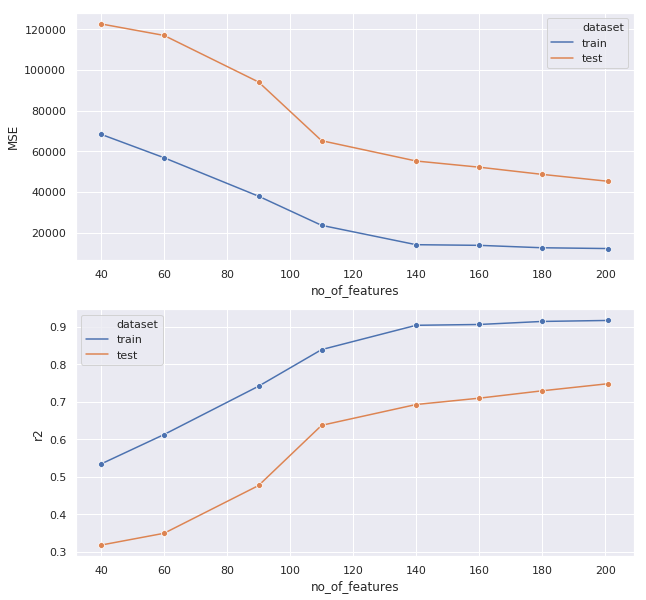

In [0]:
eval_metrics = ["MSE", "r2"]
fig, axes = plt.subplots(2, 1, figsize=(10,10))
for i, metric in enumerate(eval_metrics):
  sns.lineplot(x="no_of_features", y=metric, hue="dataset", marker="o", data=fitting_graph_df, ax=axes[i])
  plt.close(2)

### As we can see from the above fitting graph, as the model complexity goes higher, the model performs well on both testing and training data (less MSE, high r2). But very high accurracy on training data means that the model is overfitting. So, we feel that the optimal model complexity i.e. the optimal number of features is the top 110 ranked features as the model's r2 and MSE score does not vary greatly post this threshold.

# <center>This is the end of the assignment.</center>